In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def visualize_project_rankings(filenames, instruction_labels, top_color='#E65100', bottom_color='#00695C'):
    """
    Visualizes project rankings across different voting methods.
    """
    kapp_h_filename = filenames.get('kapp_h', filenames.get('kapp'))
    baseline_df = pd.read_csv(kapp_h_filename)
    midpoint = len(baseline_df) // 2
    baseline_df['Label'] = ['Top' if i < midpoint else 'Bottom' for i in range(len(baseline_df))]
    baseline_df['Alpha'] = 0.3 
    baseline_df.loc[baseline_df['Rank'] == 1, 'Alpha'] = 0.8  
    baseline_df.loc[baseline_df['Rank'] == 2, 'Alpha'] = 0.7 
    baseline_df.loc[baseline_df['Rank'] == 3, 'Alpha'] = 0.6 
    baseline_df.loc[baseline_df['Rank'] == 22, 'Alpha'] = 0.6 
    baseline_df.loc[baseline_df['Rank'] == 23, 'Alpha'] = 0.7 
    baseline_df.loc[baseline_df['Rank'] == 24, 'Alpha'] = 0.8  

    all_dfs = []

    for method, filename in filenames.items():
        df = pd.read_csv(filename)
        df = df.merge(baseline_df[['Id', 'Label']], on='Id', how='left')
        df['Method'] = method
        df['Color'] = df['Id'].map(baseline_df.set_index('Id')['Rank'].apply(lambda x: plt.cm.viridis((x-1)/(len(baseline_df)-1))))
        all_dfs.append(df)

    combined_df = pd.concat(all_dfs)
    combined_df = combined_df.merge(baseline_df[['Id', 'Alpha']], on='Id', how='left')
    combined_df['Alpha'] = combined_df['Alpha'].astype(float)

    plt.rcParams['font.family'] = 'Avenir'

    fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')  
    ax.set_facecolor('white')
    methods_order = list(instruction_labels.keys())
    combined_df['Method'] = pd.Categorical(combined_df['Method'], categories=methods_order, ordered=True)

    combined_df['Color'] = combined_df['Label'].map({'Top': top_color, 'Bottom': bottom_color})

    bar_width = 0.9
    bar_height = 0.8

    for method_pos, method in enumerate(methods_order):
        method_df = combined_df[combined_df['Method'] == method].copy()
        for _, row in method_df.iterrows():
            left_edge = method_pos - bar_width / 2
            ax.barh(y=row['Rank'], width=bar_width, height=bar_height, left=left_edge,
                    color=row['Color'], alpha=row['Alpha'], edgecolor='none')
            text_position = left_edge + 0.03
            ax.text(text_position, row['Rank'], f"{row['Id']} {row['Name'][:3]}..",
                    ha='left', va='center', fontsize=9, color='black')

    ax.set_xticks(range(len(methods_order)))
    ax.set_xticklabels([instruction_labels[method] for method in methods_order], fontsize=10, fontweight='bold', rotation=45)
    ax.set_ylabel('Rank', fontsize=12, fontweight='bold')
    mask = np.triu(np.ones_like(combined_df, dtype=bool))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both', length=0)  

    y_ticks = np.arange(1, len(baseline_df) + 1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(map(str, y_ticks))
    ax.set_xlim(-0.5, len(methods_order) - 0.5)
    ax.set_ylim(0, max(baseline_df['Rank']) + 0.5)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.1, right=0.9, left=0.05)
    plt.show()

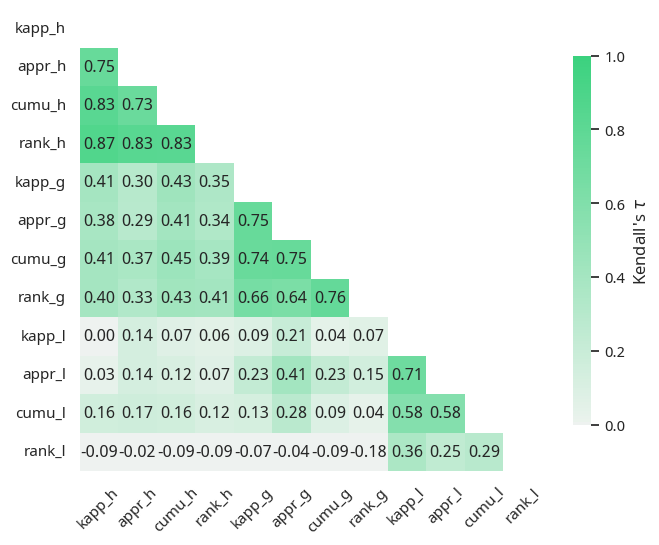

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import numpy as np
from itertools import combinations

def visualize_kendalls_tau_heatmap(filenames, instruction_labels, vmin, vmax):
    dataframes = {label: pd.read_csv(filename) for label, filename in filenames.items()}
    tau_values = pd.DataFrame(index=filenames.keys(), columns=filenames.keys())
    for (method1, df1), (method2, df2) in combinations(dataframes.items(), 2):
        merged_df = df1.merge(df2, on='Id', suffixes=('_1', '_2'))
        tau, _ = kendalltau(merged_df['Rank_1'], merged_df['Rank_2'])
        tau_values.at[method1, method2] = tau
        tau_values.at[method2, method1] = tau

    np.fill_diagonal(tau_values.values, np.nan) 
    tau_values = tau_values.astype(float)
    

    mask = np.triu(np.ones_like(tau_values, dtype=bool))

    cmap = sns.diverging_palette(220, 140, s=90, l=75, center='light', as_cmap=True)

    sns.set(style='white', font_scale=1)

    plt.figure(figsize=(8, 6))
    plt.rcParams['font.family'] = 'Noto Sans'
    ax = sns.heatmap(tau_values, cmap=cmap, center=0, cbar=True, vmin=vmin, vmax=vmax, 
                square=True, linewidths=0, annot_kws={"size": 12}, cbar_kws={"shrink": .8, 'label': 'Kendall\'s $\\tau$'}, annot=True, fmt=".2f", mask=mask)
    ax.set_facecolor('white')
    
    plt.xticks(rotation=45) 

    avg_taus = {}
    groups = {'_h': 'Human', '_g': 'GPT4T', '_l': 'LLaMA2'}
    for group_suffix, group_name in groups.items():
        group_keys = [key for key in filenames.keys() if key.endswith(group_suffix)]
        group_taus = [tau_values.at[key1, key2] for key1, key2 in combinations(group_keys, 2)]
        avg_taus[group_name] = np.nanmean(group_taus)

    # bodystr = '\n'.join(f'{group}: {avg:.2f}' for group, avg in avg_taus.items())
    # textstr = 'Average Intra-group $\\tau$:\n' + bodystr
    # props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # plt.gcf().text(0.8, 0.02, textstr, fontsize=10, bbox=props)
    plt.savefig('../figures/intra-group.pdf',format='pdf')

    plt.show()




filenames = {
    'kapp_h': 'lab_vote/outcome_lab_kapp.csv',
    'appr_h': 'lab_vote/outcome_lab_appr.csv',
    'cumu_h': 'lab_vote/outcome_lab_cumu.csv',
    'rank_h': 'lab_vote/outcome_lab_rank.csv',
    'kapp_g': 'gpt_vote/outcome_kapp.csv',
    'appr_g': 'gpt_vote/outcome_appr.csv',
    'cumu_g': 'gpt_vote/outcome_cumu_corrected.csv',
    'rank_g': 'gpt_vote/outcome_rank.csv',
    'kapp_l': 'llama_vote/outcome_llama70bq8_kapp_1.csv',
    'appr_l': 'llama_vote/outcome_llama70bq8_appr_1.csv',
    'cumu_l': 'llama_vote/outcome_llama70bq8_cumu_1_corr.csv',
    'rank_l': 'llama_vote/outcome_llama70bq8_rank_1.csv',
}

instruction_labels = {
    'kapp_h': 'kapp_h',
    'appr_h': 'appr_h',
    'cumu_h': 'cumu_h',
    'rank_h': 'rank_h',
    'kapp_g': 'kapp_g',
    'appr_g': 'appr_g',
    'cumu_g': 'cumu_g',
    'rank_g': 'rank_g',
    'kapp_l': 'kapp_l',
    'appr_l': 'appr_l',
    'cumu_l': 'cumu_l',
    'rank_l': 'rank_l',
}

visualize_kendalls_tau_heatmap(filenames, instruction_labels, 0, 1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def vis_rankings(filenames, instruction_labels, top_color='#E65100', bottom_color='#00695C'):
    """
    Visualizes project rankings across different voting methods.
    """
    baseline_filenames = {
        '_h': filenames.get('kapp_h'),
        '_g': filenames.get('kapp_g'),
        '_l': filenames.get('kapp_l'),
    }

    all_dfs = []

    for method, filename in filenames.items():
        df = pd.read_csv(filename)

        for suffix, baseline_filename in baseline_filenames.items():
            if method.endswith(suffix):
                baseline_df = pd.read_csv(baseline_filename)
                break

        midpoint = len(baseline_df) // 2
        baseline_df['Label'] = ['Top' if i < midpoint else 'Bottom' for i in range(len(baseline_df))]
        baseline_df['Alpha'] = 0.3
        baseline_df.loc[baseline_df['Rank'] == 1, 'Alpha'] = 0.8
        baseline_df.loc[baseline_df['Rank'] == 2, 'Alpha'] = 0.7
        baseline_df.loc[baseline_df['Rank'] == 3, 'Alpha'] = 0.6

        all_dfs = []


        df = df.merge(baseline_df[['Id', 'Label', 'Alpha']], on='Id', how='left')
        df['Method'] = method
        df['Color'] = df['Id'].map(baseline_df.set_index('Id')['Rank'].apply(lambda x: plt.cm.viridis((x-1)/(len(baseline_df)-1))))
        all_dfs.append(df)

    combined_df = pd.concat(all_dfs)
    combined_df = combined_df.merge(baseline_df[['Id', 'Alpha']], on='Id', how='left')
    combined_df['Alpha'] = combined_df['Alpha'].astype(float)

    plt.rcParams['font.family'] = 'Avenir'

    fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')  
    ax.set_facecolor('white')
    methods_order = list(instruction_labels.keys())
    combined_df['Method'] = pd.Categorical(combined_df['Method'], categories=methods_order, ordered=True)

    combined_df['Color'] = combined_df['Label'].map({'Top': top_color, 'Bottom': bottom_color})

    bar_width = 0.9
    bar_height = 0.8

    group_gap = 0.2 

    for method_pos, method in enumerate(methods_order):
        group_offset = (method_pos // 4) * group_gap  
        method_df = combined_df[combined_df['Method'] == method].copy()
        for _, row in method_df.iterrows():
            left_edge = method_pos - bar_width / 2 + group_offset  
            ax.barh(y=row['Rank'], width=bar_width, height=bar_height, left=left_edge,
                    color=row['Color'], alpha=row['Alpha'], edgecolor='none')
            text_position = left_edge + 0.03
            ax.text(text_position, row['Rank'], f"{row['Id']} {row['Name'][:3]}..",
                    ha='left', va='center', fontsize=9, color='black')

    ax.set_xlim(-0.5, len(methods_order) - 0.5 + group_offset * (len(methods_order) // 3))


    ax.set_xticks(range(len(methods_order)))
    ax.set_xticklabels([instruction_labels[method] for method in methods_order], fontsize=10, fontweight='bold', rotation=45)
    # ax.set_xlabel('Voting Method', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rank', fontsize=12, fontweight='bold')
    # ax.set_title('Project Rankings Across Different Voting Methods (LLAMA Voters)', fontsize=12, fontweight='bold')
    mask = np.triu(np.ones_like(combined_df, dtype=bool))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both', length=0)  

    y_ticks = np.arange(1, len(baseline_df) + 1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(map(str, y_ticks))
    ax.set_xlim(-0.5, len(methods_order) - 0.5)
    ax.set_ylim(0, max(baseline_df['Rank']) + 0.5)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.1, right=0.9, left=0.05)
    plt.show()

vis_rankings(filenames, instruction_labels)

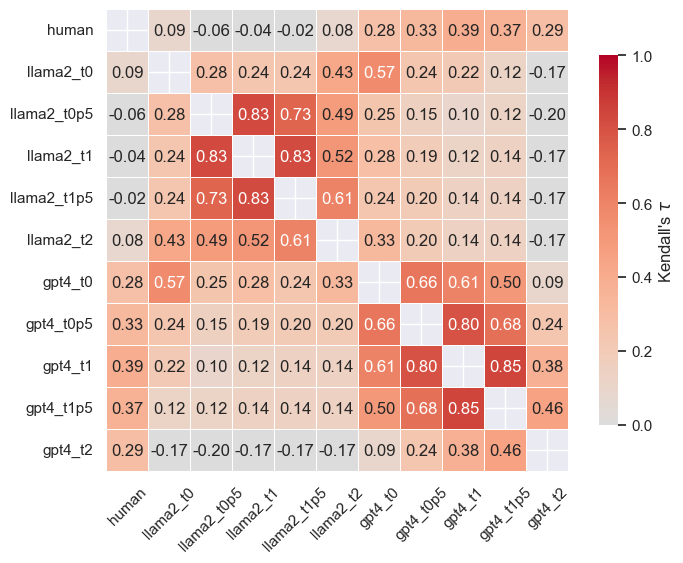

In [127]:
def visualize_kendalls_tau_heatmap(filenames, instruction_labels, vmin, vmax):
    """
    Visualizes a heatmap of Kendall's Tau coefficients for comparing different voting methods.
    """

    dataframes = {label: pd.read_csv(filename) for label, filename in filenames.items()}
    tau_values = pd.DataFrame(index=filenames.keys(), columns=filenames.keys())
    for (method1, df1), (method2, df2) in combinations(dataframes.items(), 2):
        merged_df = df1.merge(df2, on='Id', suffixes=('_1', '_2'))
        tau, _ = kendalltau(merged_df['Rank_1'], merged_df['Rank_2'])
        tau_values.at[method1, method2] = tau
        tau_values.at[method2, method1] = tau

    np.fill_diagonal(tau_values.values, np.nan) 
    tau_values = tau_values.astype(float)

    mask = np.triu(np.ones_like(tau_values, dtype=bool))
    

    cmap = sns.diverging_palette(260, 20, as_cmap=True)
    sns.set(font_scale=1)

    plt.figure(figsize=(8, 6))
    heatmap = sns.heatmap(tau_values, cmap='coolwarm', center=0, cbar=True, vmin=vmin, vmax=vmax, 
                square=True, linewidths=.5, annot_kws={"size": 12}, cbar_kws={"shrink": .8, 'label': 'Kendall\'s $\\tau$'}, annot=True, fmt=".2f")
    
    plt.xticks(rotation=45) 

    # avg_taus = {}
    # for temp_label in filenames.keys():
    #     avg_taus[temp_label] = tau_values.loc[temp_label].mean()

    # # Format the average taus for display in the plot
    # bodystr = '\n'.join(f'temp = {instruction_labels[temp]}: ${avg:.2f}$' for temp, avg in avg_taus.items())
    # textstr = 'Average $\\tau$:\n' + bodystr
    # props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # # Display the text box on the heatmap
    # plt.gcf().text(0.8, -0.2, textstr, fontsize=10, bbox=props)
    tick_labels = [f'{instruction_labels[label]}' for label in filenames.keys()]
    heatmap.set_xticklabels(tick_labels, rotation=45)
    heatmap.set_yticklabels(tick_labels, rotation=0)



    plt.show()

filenames = {
    'human': 'lab_vote/outcome_lab_kapp.csv',
    'llama2_t0': 'llama_temp/temp0/outcome.csv',
    'llama2_t0p5': 'llama_temp/temp0p5/outcome.csv',
    'llama2_t1': 'llama_temp/temp1/outcome.csv',
    'llama2_t1p5': 'llama_temp/temp1p5/outcome.csv',
    'llama2_t2': 'llama_temp/temp2/outcome.csv',
    'gpt4_t0': 'gpt_temp/temp0/outcome.csv',
    'gpt4_t0p5': 'gpt_temp/temp0p5/outcome.csv',
    'gpt4_t1': 'gpt_temp/temp1/outcome.csv',
    'gpt4_t1p5': 'gpt_temp/temp1p5/outcome.csv',
    'gpt4_t2': 'gpt_temp/temp2/outcome.csv',

}

instruction_labels = {
    'human': 'human',
    'llama2_t0': 'llama2_t0',
    'llama2_t0p5': 'llama2_t0p5',
    'llama2_t1': 'llama2_t1',
    'llama2_t1p5': 'llama2_t1p5',
    'llama2_t2': 'llama2_t2',
    'gpt4_t0': 'gpt4_t0',
    'gpt4_t0p5':'gpt4_t0p5',
    'gpt4_t1': 'gpt4_t1',
    'gpt4_t1p5': 'gpt4_t1p5',
    'gpt4_t2': 'gpt4_t2',
}

# visualize_project_rankings(filenames, instruction_labels)
visualize_kendalls_tau_heatmap(filenames, instruction_labels, 0, 1)

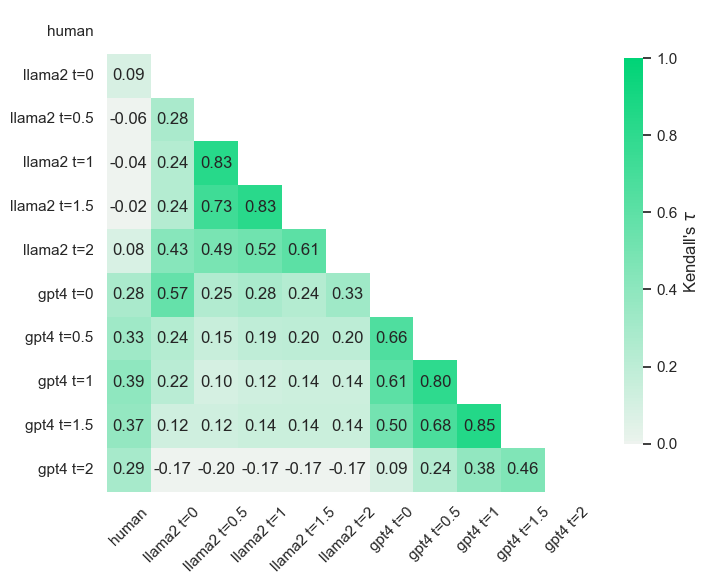

In [210]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import numpy as np
from itertools import combinations
import matplotlib

# Set the font globally for all plots
matplotlib.rc('font', family='Noto Sans')

def visualize_kendalls_tau_heatmap(filenames, instruction_labels, vmin, vmax):
    """
    Visualizes a heatmap of Kendall's Tau coefficients for comparing different voting methods.
    """
    dataframes = {label: pd.read_csv(filename) for label, filename in filenames.items()}
    tau_values = pd.DataFrame(index=filenames.keys(), columns=filenames.keys())
    for (method1, df1), (method2, df2) in combinations(dataframes.items(), 2):
        merged_df = df1.merge(df2, on='Id', suffixes=('_1', '_2'))
        tau, _ = kendalltau(merged_df['Rank_1'], merged_df['Rank_2'])
        tau_values.at[method1, method2] = tau
        tau_values.at[method2, method1] = tau

    np.fill_diagonal(tau_values.values, np.nan)
    tau_values = tau_values.astype(float)

    mask = np.triu(np.ones_like(tau_values, dtype=bool))

    cmap = sns.diverging_palette(220, 140, s=100, l=75, center='light', as_cmap=True)
    sns.set(style='white', font_scale=1.0)

    plt.figure(figsize=(8, 6))
    heatmap = sns.heatmap(tau_values, cmap=cmap, center=0, cbar=True, vmin=vmin, vmax=vmax, 
                          square=True, linewidths=0, annot_kws={"size": 12}, 
                          cbar_kws={"shrink": .8, 'label': 'Kendall\'s $\\tau$'}, 
                          annot=True, fmt=".2f", mask=mask)

    # Using the formatted labels for ticks
    formatted_labels = [instruction_labels[label] for label in tau_values.index]
    heatmap.set_xticklabels(formatted_labels, rotation=45)
    heatmap.set_yticklabels(formatted_labels, rotation=0)

    plt.tight_layout()
    plt.savefig('../figures/kendalls_tau_heatmap.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Define file paths and labels with the specified instruction_labels
filenames = {
    'human': 'lab_vote/outcome_lab_kapp.csv',
    'llama2_t0': 'llama_temp/temp0/outcome.csv',
    'llama2_t0p5': 'llama_temp/temp0p5/outcome.csv',
    'llama2_t1': 'llama_temp/temp1/outcome.csv',
    'llama2_t1p5': 'llama_temp/temp1p5/outcome.csv',
    'llama2_t2': 'llama_temp/temp2/outcome.csv',
    'gpt4_t0': 'gpt_temp/temp0/outcome.csv',
    'gpt4_t0p5': 'gpt_temp/temp0p5/outcome.csv',
    'gpt4_t1': 'gpt_temp/temp1/outcome.csv',
    'gpt4_t1p5': 'gpt_temp/temp1p5/outcome.csv',
    'gpt4_t2': 'gpt_temp/temp2/outcome.csv',
}

instruction_labels = {
    'human': 'human',
    'llama2_t0': 'llama2 t=0',
    'llama2_t0p5': 'llama2 t=0.5',
    'llama2_t1': 'llama2 t=1',
    'llama2_t1p5': 'llama2 t=1.5',
    'llama2_t2': 'llama2 t=2',
    'gpt4_t0': 'gpt4 t=0',
    'gpt4_t0p5': 'gpt4 t=0.5',
    'gpt4_t1': 'gpt4 t=1',
    'gpt4_t1p5': 'gpt4 t=1.5',
    'gpt4_t2': 'gpt4 t=2',
}

visualize_kendalls_tau_heatmap(filenames, instruction_labels, 0, 1)


posx and posy should be finite values
posx and posy should be finite values


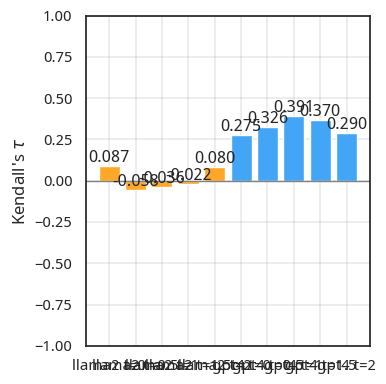

In [301]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

def visualize_kendalls_tau_barchart(filenames, instruction_labels):
    tau_values = pd.DataFrame(index=['human'], columns=filenames.keys())
    human_df = pd.read_csv(filenames['human'])
    for label, filename in filenames.items():
        if label == 'human':
            continue
        df = pd.read_csv(filename)
        merged_df = human_df.merge(df, on='Id', suffixes=('', f'_{label}'))
        tau, _ = kendalltau(merged_df['Rank'], merged_df[f'Rank_{label}'])
        tau_values.at['human', label] = tau

    tau_values = tau_values.loc['human'].astype(float)
    blue_palette = ['#42A5F5', '#1E88E5', '#1976D2', '#1565C0', '#0D47A1']
    orange_palette = ['#FFA726', '#FB8C00', '#F57C00', '#EF6C00', '#E65100']
    teal_palette = ['#26A69A']

    bar_colors = []
    for label in tau_values.index:
        if 'gpt' in instruction_labels.get(label, ''):
            bar_colors.append(blue_palette[0])
        elif 'llama' in instruction_labels.get(label, ''):
            bar_colors.append(orange_palette[0]) 
        elif 'human' in label:
            bar_colors.append(teal_palette[0])

    plt.figure(figsize=(4, 4))
    bars = plt.bar(tau_values.index, tau_values, color=bar_colors)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom')

    positions = range(1, len(tau_values.index)) 
    labels = [instruction_labels[label] for label in tau_values.index if label != 'human']

    plt.xticks(positions, labels)

    plt.grid(which='major', linestyle='-', linewidth='0.2', color='grey')
    plt.ylabel("Kendall's $\\tau$")

    plt.ylim(-1, 1)
    ax = plt.gca() 
    ax.set_facecolor('white') 
    plt.axhline(y=0, color='grey', linestyle='-', linewidth=1)

    plt.tight_layout()
    plt.show()

filenames = {
    'human': 'lab_vote/outcome_lab_kapp.csv',
    'llama2_t0': 'llama_temp/temp0/outcome.csv',
    'llama2_t0p5': 'llama_temp/temp0p5/outcome.csv',
    'llama2_t1': 'llama_temp/temp1/outcome.csv',
    'llama2_t1p5': 'llama_temp/temp1p5/outcome.csv',
    'llama2_t2': 'llama_temp/temp2/outcome.csv',
    'gpt4_t0': 'gpt_temp/temp0/outcome.csv',
    'gpt4_t0p5': 'gpt_temp/temp0p5/outcome.csv',
    'gpt4_t1': 'gpt_temp/temp1/outcome.csv',
    'gpt4_t1p5': 'gpt_temp/temp1p5/outcome.csv',
    'gpt4_t2': 'gpt_temp/temp2/outcome.csv',
}

instruction_labels = {
    'human': 'human',
    'llama2_t0': 'llama2 t=0',
    'llama2_t0p5': 'llama2 t=0.5',
    'llama2_t1': 'llama2 t=1',
    'llama2_t1p5': 'llama2 t=1.5',
    'llama2_t2': 'llama2 t=2',
    'gpt4_t0': 'gpt4 t=0',
    'gpt4_t0p5': 'gpt4 t=0.5',
    'gpt4_t1': 'gpt4 t=1',
    'gpt4_t1p5': 'gpt4 t=1.5',
    'gpt4_t2': 'gpt4 t=2',
}

visualize_kendalls_tau_barchart(filenames, instruction_labels)

posx and posy should be finite values
posx and posy should be finite values


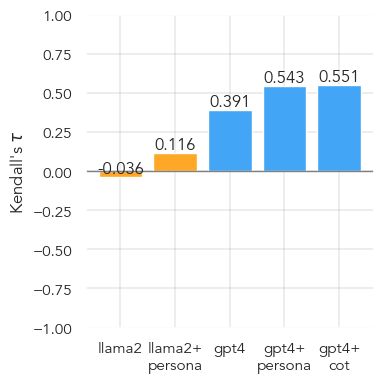

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from itertools import combinations

def visualize_kendalls_tau_barchart(filenames, instruction_labels):
    """
    Visualizes a bar chart of Kendall's Tau coefficients comparing human rankings with other methods.
    """
    
    # Prepare the DataFrame to store Kendall's Tau values
    tau_values = pd.DataFrame(index=['human'], columns=filenames.keys())
    
    # Compute Kendall's Tau values
    human_df = pd.read_csv(filenames['human'])
    for label, filename in filenames.items():
        if label == 'human':  # Skip comparing human to itself
            continue
        df = pd.read_csv(filename)
        merged_df = human_df.merge(df, on='Id', suffixes=('', f'_{label}'))
        tau, _ = kendalltau(merged_df['Rank'], merged_df[f'Rank_{label}'])
        tau_values.at['human', label] = tau

    tau_values = tau_values.loc['human'].astype(float)
    blue_palette = ['#42A5F5', '#1E88E5', '#1976D2', '#1565C0', '#0D47A1']    # GPT
    orange_palette = ['#FFA726', '#FB8C00', '#F57C00', '#EF6C00', '#E65100']  # LLaMA
    teal_palette = ['#26A69A']                                                 # Human

    bar_colors = []
    for label in tau_values.index:
        if 'gpt' in instruction_labels.get(label, ''):
            bar_colors.append(blue_palette[0])
        elif 'llama' in instruction_labels.get(label, ''):
            bar_colors.append(orange_palette[0]) 
        elif 'human' in label:
            bar_colors.append(teal_palette[0])

    plt.figure(figsize=(4, 4))
    bars = plt.bar(tau_values.index, tau_values, color=bar_colors)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom')

    positions = range(1, len(tau_values.index)) 
    labels = [instruction_labels[label] for label in tau_values.index if label != 'human']

    plt.xticks(positions, labels)

    plt.grid(which='major', linestyle='-', linewidth='0.2', color='grey')
    plt.ylabel("Kendall's $\\tau$")
    # plt.title("Comparison of Human and Model Ranking Consistency")

    plt.ylim(-1, 1)
    ax = plt.gca() 
    ax.set_facecolor('white') 
    plt.axhline(y=0, color='grey', linestyle='-', linewidth=1)

    plt.tight_layout()
    plt.show()

filenames = {
    'human': 'lab_vote/outcome_lab_kapp.csv',
    'llama2_t1': 'llama_temp/temp1/outcome.csv',
    'llama2_persona': 'llama_persona/temp1/llama2_outcomes.csv',
    'gpt4_t1': 'gpt_temp/temp1/outcome.csv',
    'gpt4_persona': 'gpt_persona/temp1/gpt_outcome.csv',
    'gpt_cot': 'gpt_cot/gpt_outcome.csv'
}

instruction_labels = {
    'llama2_t1': 'llama2',
    'llama2_persona': 'llama2+\npersona',
    'gpt4_t1': 'gpt4',
    'gpt4_persona': 'gpt4+\npersona',
    'gpt_cot': 'gpt4+\ncot'
}

visualize_kendalls_tau_barchart(filenames, instruction_labels)

In [115]:
def print_kendalls_tau_latex_table(filenames, instruction_labels):
    """
    Prints a LaTeX table of Kendall's Tau coefficients comparing human rankings with other methods.
    """
    
    # Prepare the DataFrame to store Kendall's Tau values
    tau_values = pd.DataFrame(index=['human'], columns=filenames.keys())
    
    # Compute Kendall's Tau values
    human_df = pd.read_csv(filenames['human'])
    for label, filename in filenames.items():
        if label == 'human':  # Skip comparing human to itself
            continue
        df = pd.read_csv(filename)
        merged_df = human_df.merge(df, on='Id', suffixes=('', f'_{label}'))
        tau, _ = kendalltau(merged_df['Rank'], merged_df[f'Rank_{label}'])
        tau_values.at['human', label] = tau

    # Convert the Tau values to float for sorting and print formatting
    tau_values = tau_values.astype(float)

    # Sort the columns based on the label order provided in instruction_labels
    sorted_labels = sorted(instruction_labels.keys(), key=lambda x: instruction_labels[x])
    tau_values = tau_values[sorted_labels]

    # Convert to LaTeX table format
    latex_str = tau_values.T.to_latex(header=False, float_format="{:0.3f}".format)
    print(latex_str)

# Call the function to print out the LaTeX table
print_kendalls_tau_latex_table(filenames, instruction_labels)


\begin{tabular}{lr}
\toprule
gpt4\_t1        &  0.391 \\
gpt4\_persona   &  0.543 \\
llama2\_t1      & -0.036 \\
llama2\_persona &  0.116 \\
\bottomrule
\end{tabular}



/var/folders/b5/wqbw_0tx7wv2s6m_tw4pfw7h0000gq/T/ipykernel_4873/1656209695.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_str = tau_values.T.to_latex(header=False, float_format="{:0.3f}".format)


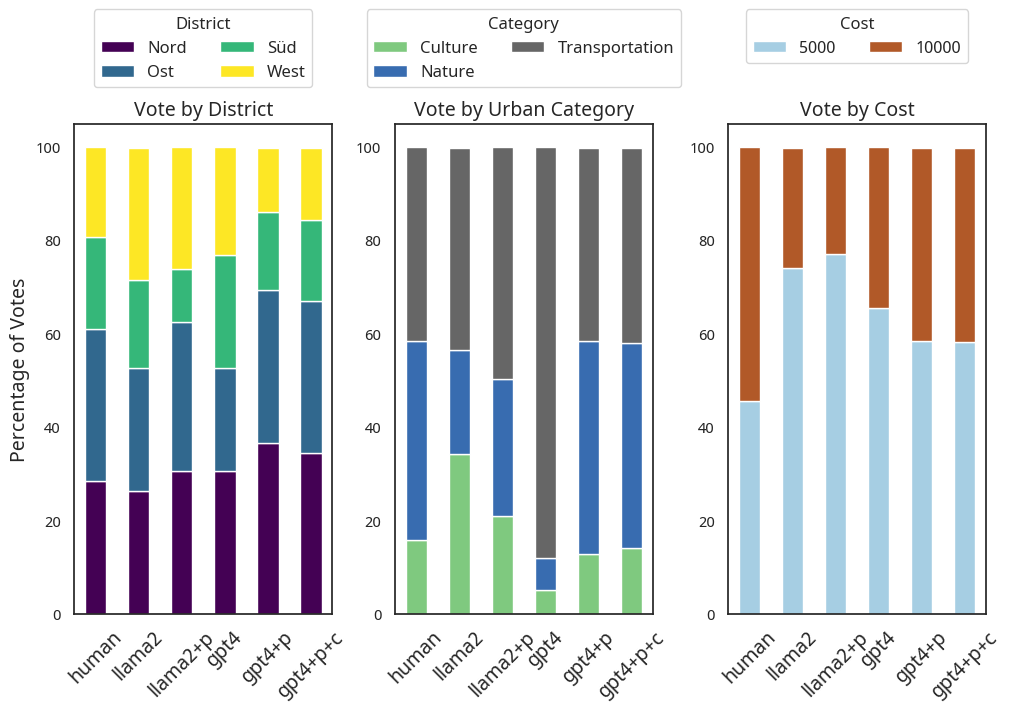

In [295]:
import pandas as pd
import matplotlib.pyplot as plt

filenames = {
    'human': 'lab_vote/outcome_lab_kapp.csv',
    'llama2_t1': 'llama_temp/temp1/outcome.csv',
    'llama2_persona': 'llama_persona/temp1/llama2_outcomes.csv',
    'gpt4_t1': 'gpt_temp/temp1/outcome.csv',
    'gpt4_persona': 'gpt_persona/temp1/gpt_outcome.csv',
    'gpt_cot': 'gpt_cot/gpt_outcome.csv'
}

instruction_labels = {
    'human': 'human',
    'llama2_t1': 'llama2',
    'llama2_persona': 'llama2+p',
    'gpt4_t1': 'gpt4',
    'gpt4_persona': 'gpt4+p',
    'gpt_cot': 'gpt4+p+c'
}

# Function to read data and calculate vote distribution by district, category, and cost
def calculate_vote_distribution(filename):
    df = pd.read_csv(filename)
    district_votes = df.groupby('District')['Votes'].sum()
    category_votes = df.groupby('Category')['Votes'].sum()
    cost_votes = df.groupby('Cost')['Votes'].sum()
    return district_votes.to_dict(), category_votes.to_dict(), cost_votes.to_dict()

# Prepare the data for stacked bar chart
all_district_votes = {}
all_category_votes = {}
all_cost_votes = {}

for key, filename in filenames.items():
    district_votes, category_votes, cost_votes = calculate_vote_distribution(filename)
    
    # Normalize the votes to the total votes and convert to percentage
    total_votes = 900  # As mentioned, the total is always 900
    for district in district_votes:
        district_votes[district] = (district_votes[district] / total_votes) * 100
    for category in category_votes:
        category_votes[category] = (category_votes[category] / total_votes) * 100
    for cost in cost_votes:
        cost_votes[cost] = (cost_votes[cost] / total_votes) * 100

    all_district_votes[key] = district_votes
    all_category_votes[key] = category_votes
    all_cost_votes[key] = cost_votes

# Convert dictionaries to DataFrames and transpose them
district_df = pd.DataFrame(all_district_votes).T.fillna(0)
category_df = pd.DataFrame(all_category_votes).T.fillna(0)
cost_df = pd.DataFrame(all_cost_votes).T.fillna(0)

# Determine the labels for x-axis
x_labels = [instruction_labels[key] for key in filenames.keys()]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(10, 7),constrained_layout=True)
plt.rcParams['font.family'] = 'Noto Sans'

# Customize font sizes
title_fontsize = 14
label_fontsize = 14
legend_fontsize = 12
tick_labelsize = 14

# Plot for 'Vote Distribution by District'
district_df.plot(kind='bar', stacked=True, ax=axes[0], colormap='viridis')
axes[0].set_title('Vote by District', fontsize=title_fontsize)
axes[0].set_ylabel('Percentage of Votes', fontsize=label_fontsize)
axes[0].legend(title='District', loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=legend_fontsize, ncol=2)
axes[0].set_xticklabels(x_labels, rotation=45, fontsize=tick_labelsize)

# Plot for 'Vote Distribution by Category'
category_df.plot(kind='bar', stacked=True, ax=axes[1], colormap='Accent')
axes[1].set_title('Vote by Urban Category', fontsize=title_fontsize)
# axes[1].set_ylabel('Percentage of Votes', fontsize=label_fontsize)
axes[1].legend(title='Category', loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=legend_fontsize, ncol=2)
axes[1].set_xticklabels(x_labels, rotation=45, fontsize=tick_labelsize)

# Plot for 'Vote Distribution by Cost'
cost_df.plot(kind='bar', stacked=True, ax=axes[2], colormap='Paired')
axes[2].set_title('Vote by Cost', fontsize=title_fontsize)
# axes[2].set_ylabel('Percentage of Votes', fontsize=label_fontsize)
axes[2].legend(title='Cost', loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=legend_fontsize, ncol=3)
axes[2].set_xticklabels(x_labels, rotation=45, fontsize=tick_labelsize)

# plt.tight_layout()
plt.savefig("../figures/voting_dist.pdf", format='pdf')
plt.show()


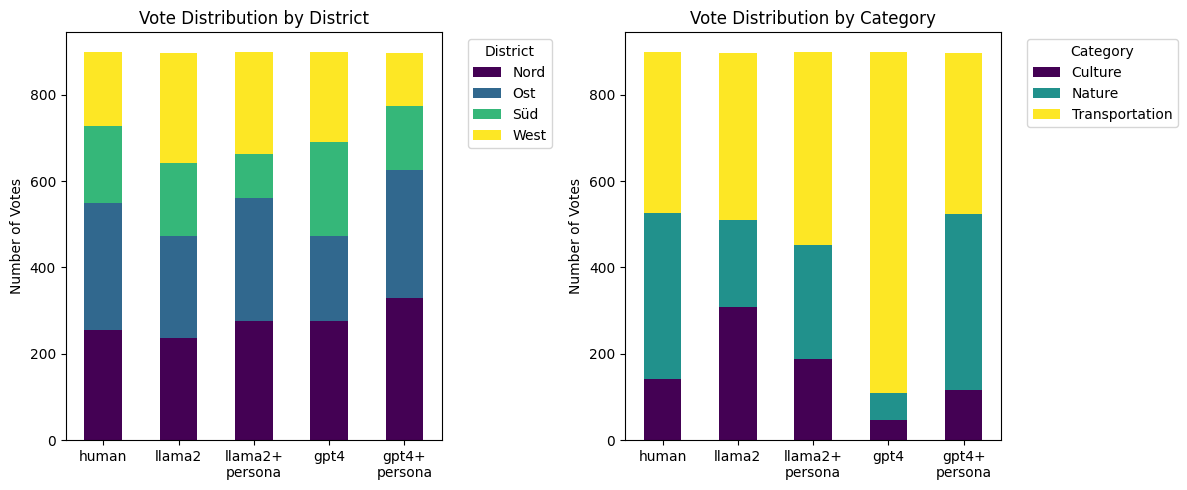

<Figure size 1000x500 with 0 Axes>

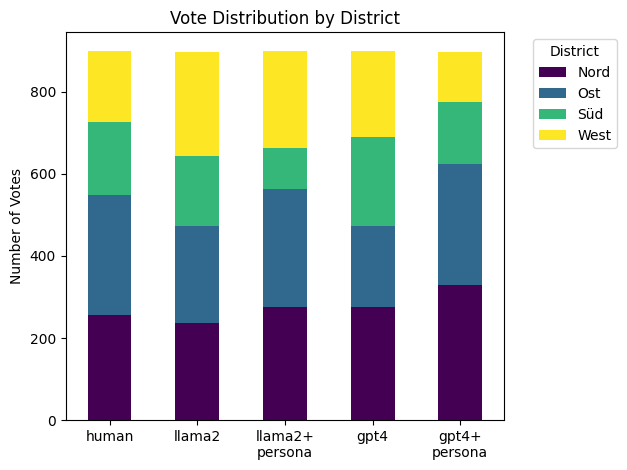

<Figure size 1000x500 with 0 Axes>

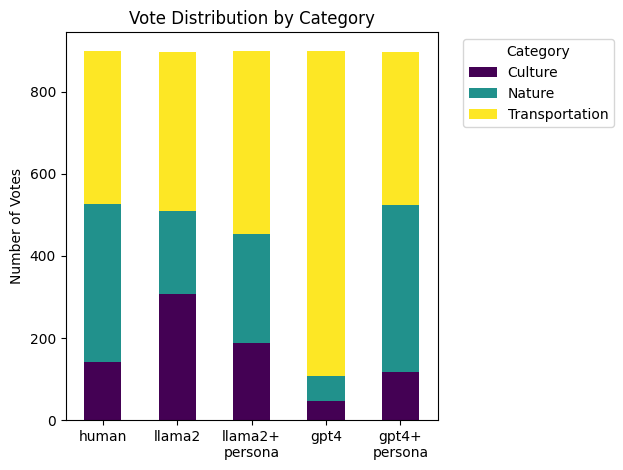

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

instruction_labels = {
    'human': 'human',
    'llama2_t1': 'llama2',
    'llama2_persona': 'llama2+\npersona',
    'gpt4_t1': 'gpt4',
    'gpt4_persona': 'gpt4+\npersona',
}

# Function to read data and calculate vote distribution by district and category
def calculate_vote_distribution(filename):
    df = pd.read_csv(filename)
    district_votes = df.groupby('District')['Votes'].sum()
    category_votes = df.groupby('Category')['Votes'].sum()
    return district_votes.to_dict(), category_votes.to_dict()

# Prepare the data for stacked bar chart
all_district_votes = {}
all_category_votes = {}

for key, filename in filenames.items():
    district_votes, category_votes = calculate_vote_distribution(filename)
    
    for district, votes in district_votes.items():
        all_district_votes.setdefault(district, []).append(votes)
        
    for category, votes in category_votes.items():
        all_category_votes.setdefault(category, []).append(votes)

# Convert to DataFrame for easier plotting
district_df = pd.DataFrame(all_district_votes)
category_df = pd.DataFrame(all_category_votes)

# Determine the labels for x-axis

x_labels = [instruction_labels[key] for key in filenames.keys()]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

# Plot for 'Vote Distribution by District'
district_df.plot(kind='bar', stacked=True, ax=axes[0], colormap='viridis')
axes[0].set_title('Vote Distribution by District')
axes[0].set_ylabel('Number of Votes')
axes[0].legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_xticklabels(x_labels, rotation=0)

# Plot for 'Vote Distribution by Category'
category_df.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
axes[1].set_title('Vote Distribution by Category')
axes[1].set_ylabel('Number of Votes')
axes[1].legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_xticklabels(x_labels, rotation=0)

plt.tight_layout()
plt.show()

x_labels = [instruction_labels[key] for key in filenames.keys()]

# Plotting for 'Vote Distribution by District'
plt.figure(figsize=(10, 5))
district_df.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Vote Distribution by District')
plt.ylabel('Number of Votes')
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(len(filenames)), labels=x_labels, rotation=0)
plt.tight_layout()
plt.show()

# Plotting for 'Vote Distribution by Category'
plt.figure(figsize=(10, 5))
category_df.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Vote Distribution by Category')
plt.ylabel('Number of Votes')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(len(filenames)), labels=x_labels, rotation=0)
plt.tight_layout()
plt.show()



In [114]:
import pandas as pd

# Function to read data and calculate vote distribution by district and category
def calculate_vote_distribution(filename):
    df = pd.read_csv(filename)
    district_votes = df.groupby('District')['Votes'].sum().sort_index()
    category_votes = df.groupby('Category')['Votes'].sum().sort_index()
    return district_votes, category_votes

# Prepare the data for CSV output
all_district_votes = pd.DataFrame()
all_category_votes = pd.DataFrame()

for key, filename in filenames.items():
    district_votes, category_votes = calculate_vote_distribution(filename)
    
    all_district_votes[key] = district_votes
    all_category_votes[key] = category_votes

# Fill NaN values with 0 for missing entries
all_district_votes = all_district_votes.fillna(0)
all_category_votes = all_category_votes.fillna(0)

# Convert to CSV format and print
print("District Votes Distribution:")
print(all_district_votes.to_csv(index=True))
print("\nCategory Votes Distribution:")
print(all_category_votes.to_csv(index=True))


District Votes Distribution:
District,human,llama2_t1,llama2_persona,gpt4_t1,gpt4_persona
Nord,255,237,275,276,330
Ost,294,237,287,198,295
Süd,178,169,102,217,150
West,173,254,235,209,123


Category Votes Distribution:
Category,human,llama2_t1,llama2_persona,gpt4_t1,gpt4_persona
Culture,142,308,189,46,116
Nature,384,201,264,62,409
Transportation,374,388,446,792,373



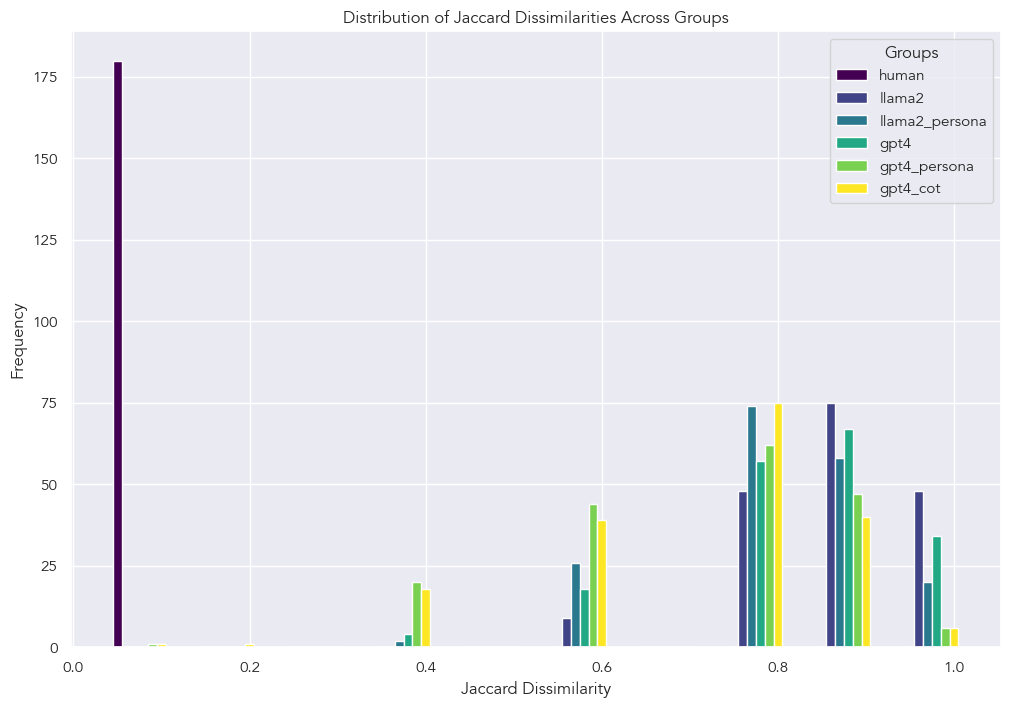

In [29]:
import json
import matplotlib.pyplot as plt
import numpy as np

def jaccard_dissimilarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return 1 - (intersection / union if union != 0 else 1)  # Return dissimilarity

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def calculate_dissimilarities(data, human_votes):
    votes_sets = [set(agent["votes"]) for agent in data]
    human_votes_sets = [set(agent["votes"]) for agent in human_votes]
    return [jaccard_dissimilarity(votes_sets[i], human_votes_sets[i]) for i in range(len(human_votes_sets))]

filenames = {
    'human': 'lab_vote/votes_kapp.json',
    'llama2': 'llama_temp/temp1/votes.json',
    'llama2_persona': 'llama_persona/temp1/llama2_votes.json',
    'gpt4': 'gpt_temp/temp1/votes.json',
    'gpt4_persona': 'gpt_persona/temp1/gpt_votes.json',
    'gpt4_cot': 'gpt_cot/gpt_votes.json',
}

dissimilarities_distributions = {}
human_votes = read_json_file('lab_vote/votes_kapp.json')

for label, filepath in filenames.items():
    data = read_json_file(filepath)
    dissimilarities = calculate_dissimilarities(data, human_votes)
    dissimilarities_distributions[label] = dissimilarities

# Plotting barcharts for each group
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Distribution of Jaccard Dissimilarities Across Groups')
colors = plt.cm.viridis(np.linspace(0, 1, len(dissimilarities_distributions)))

bins = [i * 0.1 for i in range(11)]
bin_centers = np.linspace(0.05, 0.95, 10)

for i, (group, dissimilarities) in enumerate(dissimilarities_distributions.items()):
    hist, _ = np.histogram(dissimilarities, bins=bins)
    ax.bar(bin_centers + i * 0.01, hist, width=0.01, label=group, color=colors[i])

ax.set_xlabel('Jaccard Dissimilarity')
ax.set_ylabel('Frequency')
ax.legend(title='Groups')
ax.grid(True)

plt.show()


In [26]:
import json
from itertools import combinations

def jaccard_dissimilarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 1

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def calculate_average_dissimilarity(data, human_votes):
    votes_sets = [set(agent["votes"]) for agent in data]
    human_votes_sets = [set(agent["votes"]) for agent in human_votes]
    dissimilarities = [jaccard_dissimilarity(votes_sets[i], human_votes_sets[i]) for i in range(len(human_votes_sets))]
    return sum(dissimilarities) / len(dissimilarities) if dissimilarities else 0

filenames = {
    'human': 'lab_vote/votes_kapp.json',
    'llama2': 'llama_temp/temp1/votes.json',
    'llama2_persona': 'llama_persona/temp1/llama2_votes.json',
    'gpt4': 'gpt_temp/temp1/votes.json',
    'gpt4_persona': 'gpt_persona/temp1/gpt_votes.json',
    'gpt4_cot': 'gpt_cot/gpt_votes.json',
}

average_dissimilarities = {}
human_votes = read_json_file('lab_vote/votes_kapp.json')

for label, filepath in filenames.items():
    data = read_json_file(filepath)
    average_dissimilarity = calculate_average_dissimilarity(data, human_votes)
    average_dissimilarities[label] = average_dissimilarity

print("Average Jaccard Dissimilarity:")
print("-------------------------------")
print("{:<15} {:<15}".format('Group', 'Similarity'))
for group, dissimilarity in average_dissimilarities.items():
    print("{:<15} {:<15}".format(group, dissimilarity))


Average Jaccard Dissimilarity:
-------------------------------
Group           Similarity     
human           1.0            
llama2          0.13476631393298044
llama2_persona  0.20809082892416222
gpt4            0.1781966490299822
gpt4_persona    0.3001102292768962
gpt4_cot        0.2998789482122818


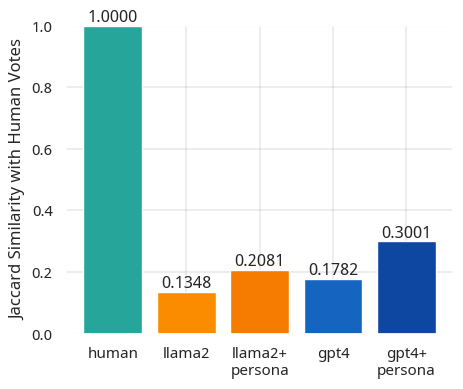

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

groups = ['human', 'llama2', 'llama2+\npersona', 'gpt4', 'gpt4+\npersona']
dissimilarities = [1.0, 0.134766, 0.208090, 0.178196, 0.300110]


blue_palette = ['#42A5F5', '#1E88E5', '#1976D2', '#1565C0', '#0D47A1']    # shades of blue for GPT
orange_palette = ['#FFA726', '#FB8C00', '#F57C00', '#EF6C00', '#E65100']  # shades of orange for LLaMA
teal_palette = ['#26A69A', '#009688', '#00897B', '#00796B', '#00695C']    # shades of teal for Human

color_map = {
    'human': teal_palette[0],
    'llama2': orange_palette[1],
    'llama2+\npersona': orange_palette[2],
    'gpt4': blue_palette[3],
    'gpt4+\npersona': blue_palette[4],
}

plt.figure(figsize=(5, 4))
plt.rcParams['font.family'] = 'Noto Sans'

for i, group in enumerate(groups):
    plt.bar(group, dissimilarities[i], color=color_map[group], label=group)
    plt.text(i, dissimilarities[i], f'{dissimilarities[i]:.4f}', ha='center', va='bottom')

plt.ylabel('Jaccard Similarity with Human Votes')
# plt.title('Comparison of Voting Pattern Diversity')
plt.ylim(0, 1)  
plt.grid(which='major', linestyle='-', linewidth='0.2', color='grey')
plt.minorticks_on()
# plt.xticks(rotation=30)  
ax = plt.gca()  
ax.set_facecolor('white') 

ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.legend
plt.show()


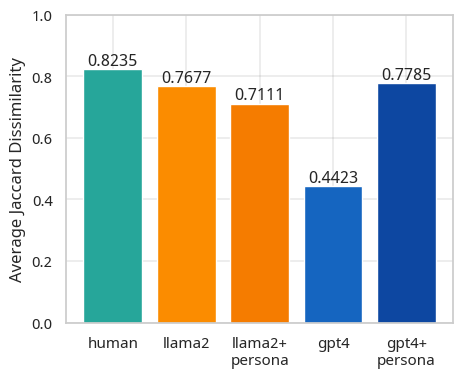

In [124]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

groups = ['human', 'llama2', 'llama2+\npersona', 'gpt4', 'gpt4+\npersona']
dissimilarities = [0.8235, 0.7677, 0.7111, 0.4423, 0.7785]

blue_palette = ['#42A5F5', '#1E88E5', '#1976D2', '#1565C0', '#0D47A1']    # shades of blue for GPT
orange_palette = ['#FFA726', '#FB8C00', '#F57C00', '#EF6C00', '#E65100']  # shades of orange for LLaMA
teal_palette = ['#26A69A', '#009688', '#00897B', '#00796B', '#00695C']    # shades of teal for Human

color_map = {
    'human': teal_palette[0],
    'llama2': orange_palette[1],
    'llama2+\npersona': orange_palette[2],
    'gpt4': blue_palette[3],
    'gpt4+\npersona': blue_palette[4],
}

plt.figure(figsize=(5, 4))
plt.rcParams['font.family'] = 'Noto Sans'

for i, group in enumerate(groups):
    plt.bar(group, dissimilarities[i], color=color_map[group], label=group)
    plt.text(i, dissimilarities[i], f'{dissimilarities[i]:.4f}', ha='center', va='bottom')

# plt.xlabel('Group')
plt.ylabel('Average Jaccard Dissimilarity')
# plt.title('Comparison of Voting Pattern Diversity')
plt.ylim(0, 1)  # Jaccard dissimilarity ranges from 0 to 1
plt.grid(which='major', linestyle='-', linewidth='0.2', color='grey')
plt.minorticks_on()
# plt.xticks(rotation=30)  
ax = plt.gca()  # Get the current axes
ax.set_facecolor('white') 

# Set up the minor tick locator
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.legend

plt.show()


Average Jaccard Dissimilarity:
-------------------------------
Group           Dissimilarity  
human           0.8234885657138524
gpt4_t0         0.16677012207739203
gpt4_t0p5       0.27857857192122565
gpt4_t1         0.44234232902754833
gpt4_t1p5       0.6729434542283763
gpt4_t2         0.8227007034967687
llama2_t0       0.0            
llama2_t0p5     0.6864451735587722
llama2_t1       0.767685406875345
llama2_t1p5     0.7981639866788631
llama2_t2       0.8586879566395221


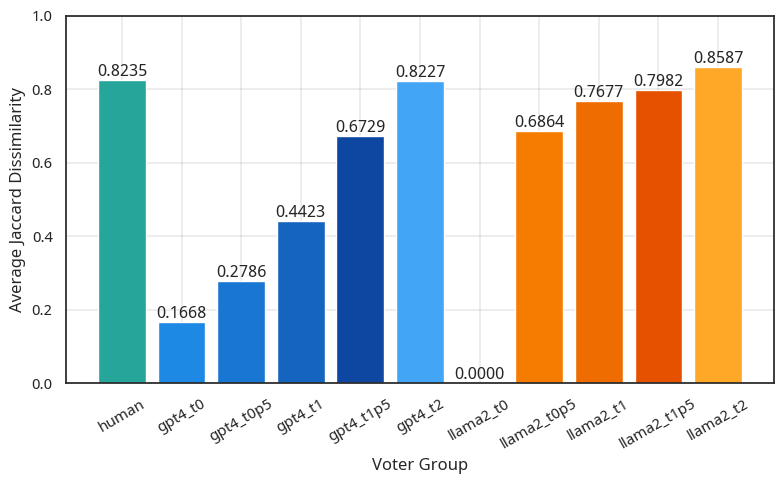

In [172]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

def calculate_average_dissimilarity(data):
    votes_sets = [set(agent["votes"]) for agent in data]
    dissimilarities = [jaccard_dissimilarity(set1, set2) for set1, set2 in combinations(votes_sets, 2)]
    return sum(dissimilarities) / len(dissimilarities) if dissimilarities else 0

filenames = {
    'human': 'lab_vote/votes_kapp.json',
    'gpt4_t0': 'gpt_temp/temp0/votes.json',
    'gpt4_t0p5': 'gpt_temp/temp0p5/votes.json',
    'gpt4_t1': 'gpt_temp/temp1/votes.json',
    'gpt4_t1p5': 'gpt_temp/temp1p5/votes.json',
    'gpt4_t2': 'gpt_temp/temp2/votes.json',
    'llama2_t0': 'llama_temp/temp0/votes.json',
    'llama2_t0p5': 'llama_temp/temp0p5/votes.json',
    'llama2_t1': 'llama_temp/temp1/votes.json',
    'llama2_t1p5': 'llama_temp/temp1p5/votes.json',
    'llama2_t2': 'llama_temp/temp2/votes.json',

}

average_dissimilarities = {}

for label, filepath in filenames.items():
    data = read_json_file(filepath)
    average_dissimilarity = calculate_average_dissimilarity(data)
    average_dissimilarities[label] = average_dissimilarity

print("Average Jaccard Dissimilarity:")
print("-------------------------------")
print("{:<15} {:<15}".format('Group', 'Dissimilarity'))
for group, dissimilarity in average_dissimilarities.items():
    print("{:<15} {:<15}".format(group, dissimilarity))

groups = list(average_dissimilarities.keys())
dissimilarities = list(average_dissimilarities.values())

blue_palette = ['#42A5F5', '#1E88E5', '#1976D2', '#1565C0', '#0D47A1']    
orange_palette = ['#FFA726', '#FB8C00', '#F57C00', '#EF6C00', '#E65100']  
teal_palette = ['#26A69A']                                                

color_map = {}
for i, label in enumerate(groups):
    if 'gpt' in label:
        color_map[label] = blue_palette[i % len(blue_palette)]
    elif 'llama' in label:
        color_map[label] = orange_palette[i % len(orange_palette)]
    elif 'human' in label:
        color_map[label] = teal_palette[0]

plt.figure(figsize=(8, 5))
plt.rcParams['font.family'] = 'Noto Sans'

for i, group in enumerate(groups):
    plt.bar(group, dissimilarities[i], color=color_map[group], label=group)
    plt.text(i, dissimilarities[i], f'{dissimilarities[i]:.4f}', ha='center', va='bottom')

plt.xlabel('Voter Group')
plt.ylabel('Average Jaccard Dissimilarity')
# plt.title('Comparison of Voting Pattern Diversity Across Models and Temperatures')
plt.ylim(0, 1)  
plt.xticks(rotation=30)  
plt.grid(which='major', linestyle='-', linewidth='0.2', color='grey')

ax = plt.gca()  
ax.set_facecolor('white')  

plt.gcf().set_facecolor('white')  

plt.tight_layout()
plt.show()


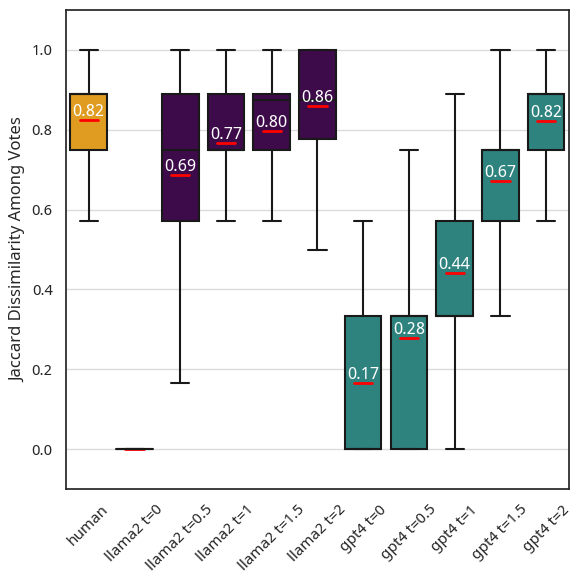

In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import json

def read_json_file(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

def jaccard_dissimilarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 1  # Return maximum dissimilarity if there is no union
    return 1 - intersection / union

def calculate_dissimilarities(data):
    votes_sets = [set(agent["votes"]) for agent in data]
    return [jaccard_dissimilarity(set1, set2) for set1, set2 in combinations(votes_sets, 2)]

filenames = {
    'human': 'lab_vote/votes_kapp.json',
    'llama2 t=0': 'llama_temp/temp0/votes.json',
    'llama2 t=0.5': 'llama_temp/temp0p5/votes.json',
    'llama2 t=1': 'llama_temp/temp1/votes.json',
    'llama2 t=1.5': 'llama_temp/temp1p5/votes.json',
    'llama2 t=2': 'llama_temp/temp2/votes.json',
    'gpt4 t=0': 'gpt_temp/temp0/votes.json',
    'gpt4 t=0.5': 'gpt_temp/temp0p5/votes.json',
    'gpt4 t=1': 'gpt_temp/temp1/votes.json',
    'gpt4 t=1.5': 'gpt_temp/temp1p5/votes.json',
    'gpt4 t=2': 'gpt_temp/temp2/votes.json',
}

dissimilarities_data = []

for label, filepath in filenames.items():
    data = read_json_file(filepath)
    dissimilarities = calculate_dissimilarities(data)
    for dissimilarity in dissimilarities:
        dissimilarities_data.append({'group': label, 'dissimilarity': dissimilarity})

df = pd.DataFrame(dissimilarities_data)

# Define colors for each group
colors = {
    'human': '#ffa600',
    'gpt4': '#21918c',
    'llama2': '#440154'
}

# Map each label to its respective color
color_map = {label: colors['gpt4'] if 'gpt4' in label else colors['llama2'] if 'llama2' in label else colors['human'] for label in df['group'].unique()}

plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'Noto Sans'
ax = sns.boxplot(x='group', y='dissimilarity', data=df, palette=color_map, showfliers=False)

# Annotating the mean on each boxplot
for i, group in enumerate(df['group'].unique()):
    group_data = df[df['group'] == group]['dissimilarity']
    mean = group_data.mean()
    plt.plot([i-0.2, i+0.2], [mean, mean], color='red', lw=2)  # short red line for mean
    plt.text(i, mean, f'{mean:.2f}', color='white', ha='center', va='bottom')  # mean value text
ax.set(xlabel=None)
# plt.xlabel('Voter Group')
plt.ylabel('Jaccard Dissimilarity Among Votes')
plt.ylim(-0.1, 1.1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.savefig('../figures/jaccard-diversity.pdf', format='pdf')
plt.show()


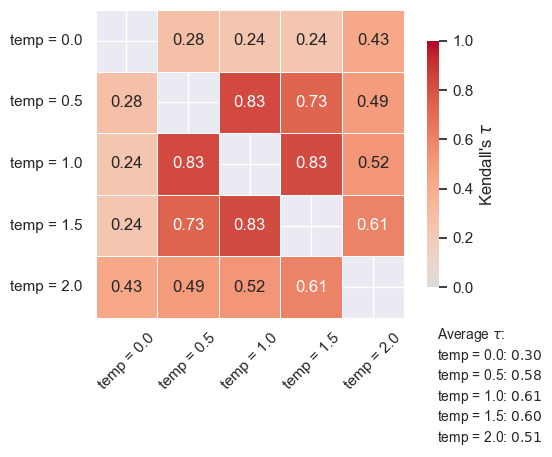

In [33]:

filenames = {
    'temp0': 'llama_temp/temp0/outcome.csv',
    'temp0p5': 'llama_temp/temp0p5/outcome.csv',
    'temp1': 'llama_temp/temp1/outcome.csv',
    'temp1p5': 'llama_temp/temp1p5/outcome.csv',
    'temp2': 'llama_temp/temp2/outcome.csv'
}

instruction_labels = {
    'temp0': '0.0',
    'temp0p5': '0.5',
    'temp1': '1.0',
    'temp1p5': '1.5',
    'temp2': '2.0'
}

# visualize_project_rankings(filenames, instruction_labels)
visualize_kendalls_tau_heatmap(filenames, instruction_labels, 0, 1)

random 28.38888888888889
human 46.55555555555556
llama2 28.962962962962962
llama2+p 50.09722222222222
gpt4 34.833333333333336
gpt4+p 66.05555555555556
gpt4+p+c 64.42857142857143


/var/folders/b5/wqbw_0tx7wv2s6m_tw4pfw7h0000gq/T/ipykernel_13415/2148170154.py:118: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=total_df, x='variable', hue='Type', y='Percentage',


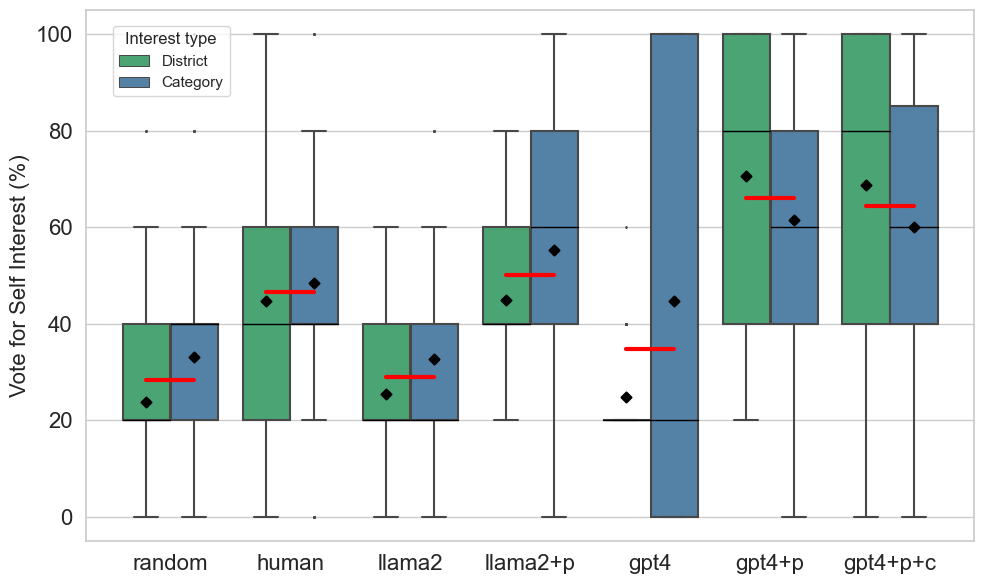

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random

voter_meta_df = pd.read_csv('../lab_data/lab_meta.csv')
voter_meta = voter_meta_df[['1st Topic', 'District']].to_dict(orient='records')

def simulate_random_votes(num_voters, num_projects, num_choices):
    random_votes = []
    for _ in range(num_voters):
        vote = random.sample(range(1, num_projects + 1), num_choices)
        random_votes.append({"votes": vote})
    return random_votes

random_responses = simulate_random_votes(180, 24, 5)

filenames = {
    'random': random_responses,
    'human': 'lab_vote/votes_kapp.json',
    'llama2': 'llama_temp/temp1/votes.json',
    'llama2+p': 'llama_persona/temp1/llama2_votes.json',
    'gpt4': 'gpt_temp/temp1/votes.json',
    'gpt4+p': 'gpt_persona/temp1/gpt_votes.json',
    'gpt4+p+c': 'gpt_cot/gpt_votes.json',
}

project_mapping = {
    1: {"District": "Nord", "Category": "Nature"},
    2: {"District": "Nord", "Category": "Nature"},
    3: {"District": "Nord", "Category": "Culture"},
    4: {"District": "Nord", "Category": "Culture"},
    5: {"District": "Nord", "Category": "Transport"},
    6: {"District": "Nord", "Category": "Transport"},
    7: {"District": "Süd", "Category": "Nature"},
    8: {"District": "Süd", "Category": "Nature"},
    9: {"District": "Süd", "Category": "Culture"},
    10: {"District": "Süd", "Category": "Culture"},
    11: {"District": "Süd", "Category": "Transport"},
    12: {"District": "Süd", "Category": "Transport"},
    13: {"District": "Ost", "Category": "Nature"},
    14: {"District": "Ost", "Category": "Nature"},
    15: {"District": "Ost", "Category": "Culture"},
    16: {"District": "Ost", "Category": "Culture"},
    17: {"District": "Ost", "Category": "Transport"},
    18: {"District": "Ost", "Category": "Transport"},
    19: {"District": "West", "Category": "Nature"},
    20: {"District": "West", "Category": "Nature"},
    21: {"District": "West", "Category": "Culture"},
    22: {"District": "West", "Category": "Culture"},
    23: {"District": "West", "Category": "Transport"},
    24: {"District": "West", "Category": "Transport"},
}

def calculate_vote_percentages(data, voter_meta):
    if isinstance(data,str):
        with open(data, 'r') as file:
            responses = json.load(file)
    else: 
        responses = data

    district_vote_percentages = []
    category_vote_percentages = []

    for i, response in enumerate(responses):
        voter_district = voter_meta[i]['District']
        voter_category = voter_meta[i]['1st Topic']

        votes = response["votes"]
        district_vote_sum = 0
        category_vote_sum = 0
        total_vote_sum = len(votes)
        
        for project_id in votes:
            project_district = project_mapping[project_id]["District"]
            project_category = project_mapping[project_id]["Category"]

            if project_district == voter_district:
                district_vote_sum += 1
            if project_category == voter_category:
                category_vote_sum += 1

        district_vote_percentages.append((district_vote_sum / total_vote_sum) * 100)
        category_vote_percentages.append((category_vote_sum / total_vote_sum) * 100)

    return district_vote_percentages, category_vote_percentages

all_district_percentages = []
all_category_percentages = []

for key, filename in filenames.items():
    district_percentages, category_percentages = calculate_vote_percentages(filename, voter_meta)
    all_district_percentages.append(district_percentages)
    all_category_percentages.append(category_percentages)


district_df = pd.DataFrame(all_district_percentages).T
district_df.columns = [key for key in filenames]
district_df['Type'] = 'District'

category_df = pd.DataFrame(all_category_percentages).T
category_df.columns = [key for key in filenames]
category_df['Type'] = 'Category'

total_df = pd.concat([district_df.melt(id_vars='Type', value_name='Percentage'), 
                      category_df.melt(id_vars='Type', value_name='Percentage')])

sns.set_style("whitegrid")
palette = sns.color_palette(["mediumseagreen", "steelblue"])

plt.figure(figsize=(10, 6))
# ax = sns.swarmplot(data=total_df, x='variable', hue='Type', y='Percentage', palette=palette) 
ax = sns.boxplot(data=total_df, x='variable', hue='Type', y='Percentage', palette=palette,
                 medianprops=dict(linewidth=1, color='black'), fliersize=1) 
handles, labels = ax.get_legend_handles_labels()

sns.pointplot(data=total_df, x='variable', hue='Type', y='Percentage', 
              dodge=0.4, join=False, palette=['black'], markers='D', 
              scale=0.75, ci=None, ax=ax)

for i in range(len(filenames)):
    mean = total_df[total_df['variable'] == list(filenames.keys())[i]]['Percentage'].mean()
    print(list(filenames.keys())[i],mean)
    plt.plot([i - 0.2, i + 0.2], [mean, mean], color='red', lw=3)
plt.ylabel('Vote for Self Interest (%)', fontsize=16)  
plt.xlabel('', fontsize=16)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)  
plt.ylim(-5, 105)
plt.tight_layout()
plt.legend(handles[:2], labels[:2], title='Interest type', bbox_to_anchor=(0.03, 0.97), loc='upper left', borderaxespad=0)
plt.savefig('../figures/self.pdf', format='pdf')
plt.show()

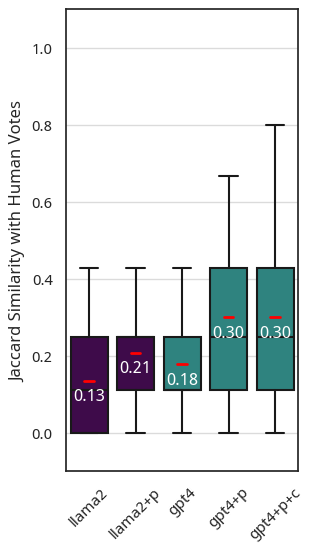

In [298]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def calculate_similarities(data, human_votes):
    votes_sets = [set(agent["votes"]) for agent in data]
    human_votes_sets = [set(agent["votes"]) for agent in human_votes]
    return [jaccard_similarity(votes_sets[i], human_votes_sets[i]) for i in range(len(human_votes_sets))]

filenames = {
    'llama2': 'llama_temp/temp1/votes.json',
    'llama2+p': 'llama_persona/temp1/llama2_votes.json',
    'gpt4': 'gpt_temp/temp1/votes.json',
    'gpt4+p': 'gpt_persona/temp1/gpt_votes.json',
    'gpt4+p+c': 'gpt_cot/gpt_votes.json',
}

all_similarities = {}
human_votes = read_json_file('lab_vote/votes_kapp.json')

for label, filepath in filenames.items():
    data = read_json_file(filepath)
    similarities = calculate_similarities(data, human_votes)
    all_similarities[label] = similarities

plt.figure(figsize=(3, 6))

# Assign color palettes based on model type
color_map = {
    'llama2': '#440154',
    'llama2+p': '#440154',
    'gpt4': '#21918c',
    'gpt4+p': '#21918c',
    'gpt4+p+c': '#21918c',
}

palette = [color_map[label] for label in filenames.keys()]
sns.boxplot(data=list(all_similarities.values()), palette=palette, showfliers=False)
plt.xticks(range(len(filenames)), list(filenames.keys()), rotation=45)
plt.ylabel('Jaccard Similarity with Human Votes')
plt.ylim(-0.1, 1.1)

means = [np.mean(sim) for sim in all_similarities.values()]
for i, mean in enumerate(means):
    plt.plot([i-0.1, i+0.1], [mean, mean], color='red', lw=2)
    # Adjust the text placement further down
    plt.text(i, mean-0.02, f'{mean:.2f}', color='white', ha='center', va='top', fontsize=12)

handles = [Line2D([0], [0], color='red', lw=2)]
# labels = ['Mean']
# plt.legend(handles, labels, title='Statistics', bbox_to_anchor=(0.76, 1), loc='upper left')
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.show()


In [299]:
from scipy.stats import ttest_ind

gpt4_p_similarities = all_similarities['gpt4+p']
gpt4_p_c_similarities = all_similarities['gpt4+p+c']

t_stat, p_value = ttest_ind(gpt4_p_similarities, gpt4_p_c_similarities, equal_var=False)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: 0.011857964485254049, P-value: 0.9905455452590803


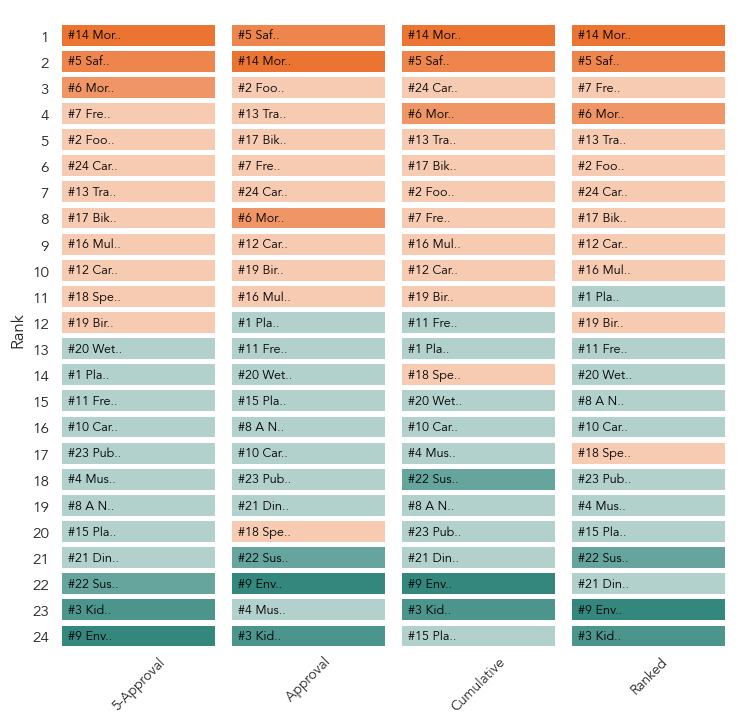

/var/folders/b5/wqbw_0tx7wv2s6m_tw4pfw7h0000gq/T/ipykernel_13415/1931808496.py:41: RuntimeWarning: Mean of empty slice
  avg_taus[group_name] = np.nanmean(group_taus)


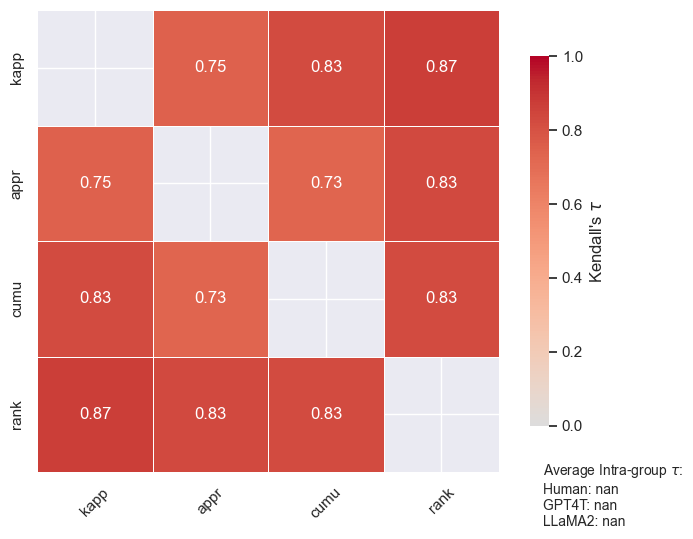

In [3]:
filenames = {
    'kapp': 'lab_vote/outcome_lab_kapp.csv',
    'appr': 'lab_vote/outcome_lab_appr.csv',
    'cumu': 'lab_vote/outcome_lab_cumu.csv',
    'rank': 'lab_vote/outcome_lab_rank.csv',
}

instruction_labels = {
    'kapp': "5-Approval",
    'appr': "Approval",
    'cumu': "Cumulative",
    'rank': "Ranked",
}

visualize_project_rankings(filenames, instruction_labels)
visualize_kendalls_tau_heatmap(filenames, instruction_labels, 0, 1)


In [4]:
filenames = {
    'gpt_persona': 'outcome/gpt_persona/gpt_outcome.csv',
    'gpt_persona_cot': 'outcome/gpt_cot/gpt_outcome.csv',
}

instruction_labels = {
    'gpt with persona': 'outcome/gpt_persona/temp1/gpt_outcome.csv',
    'gpt with Chain of Thoughts': 'outcome/gpt_cot/gpt_outcome.csv',
}

visualize_project_rankings(filenames, instruction_labels)
visualize_kendalls_tau_heatmap(filenames, instruction_labels, 0, 1)

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

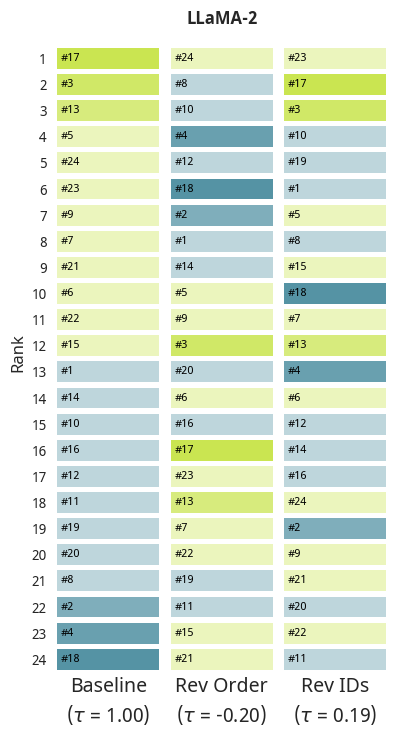

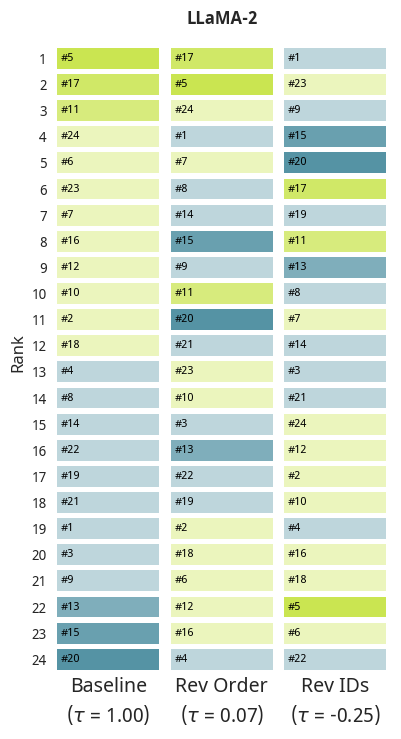

In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_kendalls_tau(filenames, baseline_filename):
    baseline_df = pd.read_csv(baseline_filename)
    tau_values = {}
    for method, filename in filenames.items():
        df = pd.read_csv(filename)
        merged_df = baseline_df.merge(df, on='Id', suffixes=('_1', '_2'))
        tau, _ = kendalltau(merged_df['Rank_1'], merged_df['Rank_2'])
        tau_values[method] = tau
    return tau_values

def visualize_project_rankings(filenames, instruction_labels, top_color='#bddf26', bottom_color='#2a788e'):
    """
    Visualizes project rankings across different voting methods.
    """

    tau_values = calculate_kendalls_tau(filenames, filenames['kapp'])
    updated_instruction_labels = {}
    for method, label in instruction_labels.items():
        tau_str = f"\n($\\tau$ = {tau_values[method]:.2f})" if method in tau_values else ""
        updated_instruction_labels[method] = label + tau_str 

    kapp_h_filename = filenames.get('kapp_h', filenames.get('kapp'))
    baseline_df = pd.read_csv(kapp_h_filename)
    midpoint = len(baseline_df) // 2
    baseline_df['Label'] = ['Top' if i < midpoint else 'Bottom' for i in range(len(baseline_df))]
    baseline_df['Alpha'] = 0.3 
    baseline_df.loc[baseline_df['Rank'] == 1, 'Alpha'] = 0.8  
    baseline_df.loc[baseline_df['Rank'] == 2, 'Alpha'] = 0.7 
    baseline_df.loc[baseline_df['Rank'] == 3, 'Alpha'] = 0.6 
    baseline_df.loc[baseline_df['Rank'] == 22, 'Alpha'] = 0.6 
    baseline_df.loc[baseline_df['Rank'] == 23, 'Alpha'] = 0.7 
    baseline_df.loc[baseline_df['Rank'] == 24, 'Alpha'] = 0.8  

    all_dfs = []

    for method, filename in filenames.items():
        df = pd.read_csv(filename)
        df = df.merge(baseline_df[['Id', 'Label']], on='Id', how='left')
        df['Method'] = method
        df['Color'] = df['Id'].map(baseline_df.set_index('Id')['Rank'].apply(lambda x: plt.cm.viridis((x-1)/(len(baseline_df)-1))))
        all_dfs.append(df)

    combined_df = pd.concat(all_dfs)
    combined_df = combined_df.merge(baseline_df[['Id', 'Alpha']], on='Id', how='left')
    combined_df['Alpha'] = combined_df['Alpha'].astype(float)

    plt.rcParams['font.family'] = 'Noto Sans'

    fig, ax = plt.subplots(figsize=(4, 8), facecolor='white')  
    ax.set_facecolor('white')
    methods_order = list(instruction_labels.keys())
    combined_df['Method'] = pd.Categorical(combined_df['Method'], categories=methods_order, ordered=True)

    combined_df['Color'] = combined_df['Label'].map({'Top': top_color, 'Bottom': bottom_color})

    bar_width = 0.9
    bar_height = 0.8

    for method_pos, method in enumerate(methods_order):
        method_df = combined_df[combined_df['Method'] == method].copy()
        for _, row in method_df.iterrows():
            left_edge = method_pos - bar_width / 2
            ax.barh(y=row['Rank'], width=bar_width, height=bar_height, left=left_edge,
                    color=row['Color'], alpha=row['Alpha'], edgecolor='none')
            text_position = left_edge + 0.03
            ax.text(text_position, row['Rank'], f"{row['Id']}",
                      ha='left', va='center', fontsize=8, color='black')
            # ax.text(text_position, row['Rank'], f"{row['Id']} {row['Name'][:13]}..",
            #         ha='left', va='center', fontsize=8, color='black')

    ax.set_xticks(range(len(methods_order)))
    ax.set_xticklabels([updated_instruction_labels[method] for method in methods_order], fontsize=14, rotation=0)

    # ax.set_xlabel('Voting Method', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rank', fontsize=12)
    ax.set_title('LLaMA-2', fontsize=12, fontweight='bold')
    mask = np.triu(np.ones_like(combined_df, dtype=bool))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both', length=0)  

    y_ticks = np.arange(1, len(baseline_df) + 1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(map(str, y_ticks), fontsize=10)
    ax.set_xlim(-0.5, len(methods_order) - 0.5)
    ax.set_ylim(0, max(baseline_df['Rank']) + 0.5)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.1, right=0.9, left=0.05)
    plt.show()

filenames = {
    'kapp': 'llama_vote/outcome_llama70bq8_kapp_1.csv',
    'rev_id': 'llama_vote/outcome_llama70bq8_reversed_id_1.csv',
    'rev_order': 'llama_vote/outcome_llama70bq8_reversed_order_1.csv'
}

instruction_labels = {
    'kapp': "Baseline",
    'rev_order': "Rev Order",
    'rev_id': "Rev IDs"
}

visualize_project_rankings(filenames, instruction_labels)

filenames = {
    'kapp': 'gpt_vote/outcome_kapp.csv',
    'rev_id': 'gpt_vote/outcome_reversed_id.csv',
    'rev_order': 'gpt_vote/outcome_reversed_order.csv'
}

instruction_labels = {
    'kapp': "Baseline",
    'rev_order': "Rev Order",
    'rev_id': "Rev IDs"
}

visualize_project_rankings(filenames, instruction_labels)

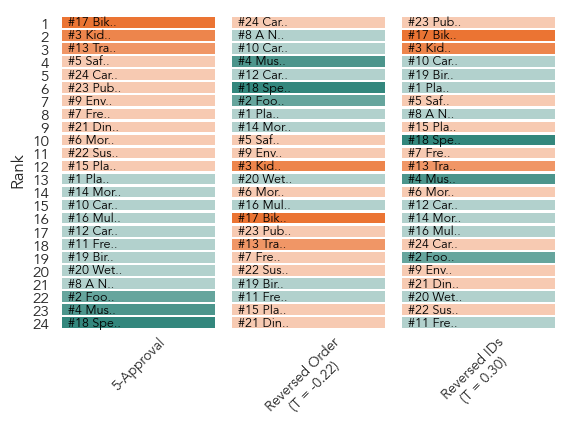

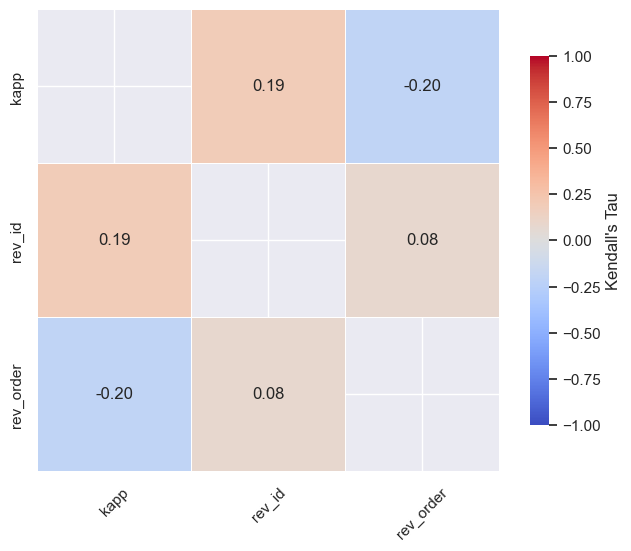

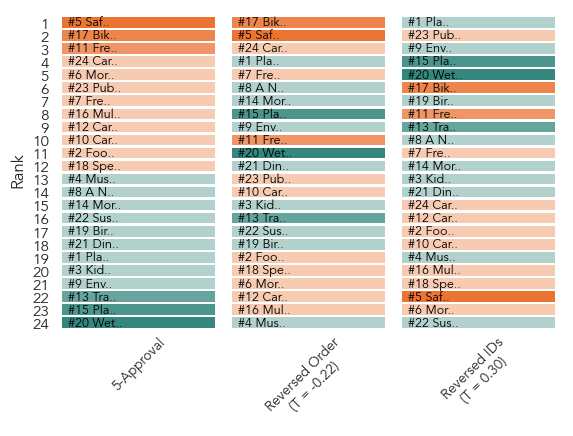

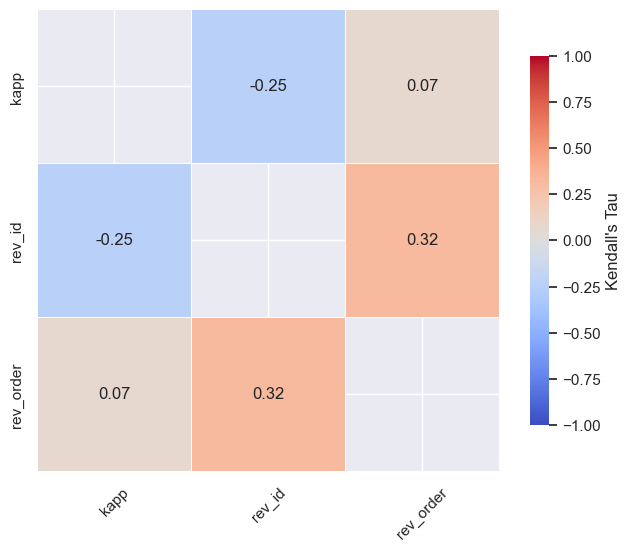

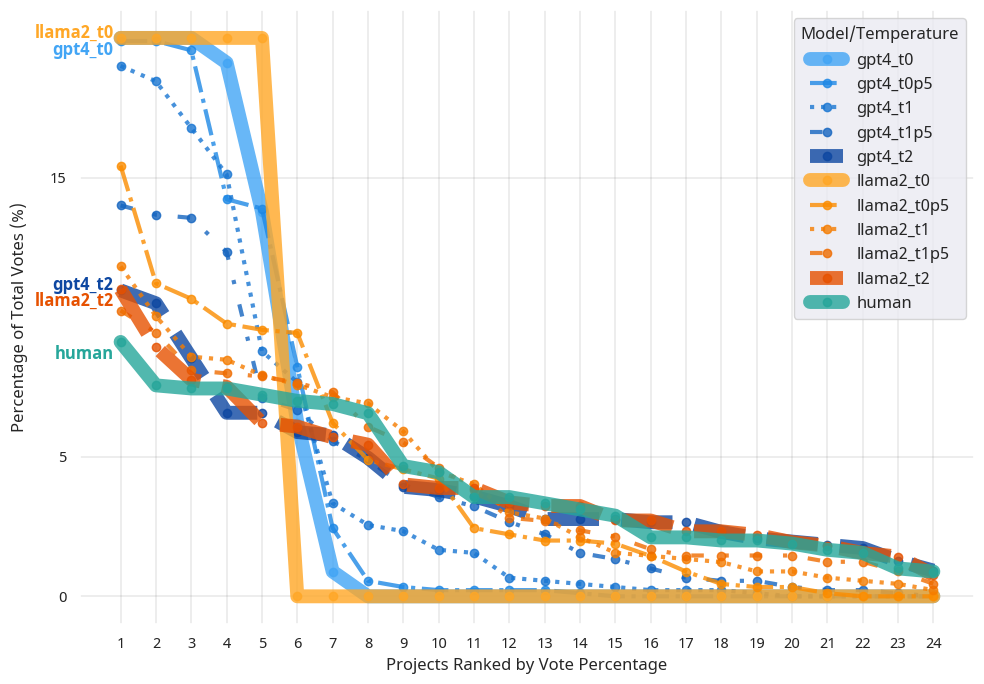

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from itertools import cycle

def visualize_vote_percentages_sorted_with_ids(filenames, color_scheme):
    """
    Visualizes the vote percentage of each project for each outcome file, sorted in descending order,
    with annotations for project IDs. Uses different color schemes for GPT and LLaMA data.
    """



    blue_palette = ['#42A5F5', '#1E88E5', '#1976D2', '#1565C0', '#0D47A1']   
    orange_palette = ['#FFA726', '#FB8C00', '#F57C00', '#EF6C00', '#E65100']  
    teal_palette = ['#26A69A', '#009688', '#00897B', '#00796B', '#00695C']   

    line_styles = ['-', '-.', ':', (0, (3, 5, 1, 5)),'--'] 
    line_weights = {'llama2_t0': 10, 'llama2_t2': 10, 'gpt4_t0': 10, 'gpt4_t2': 10, 'human': 10}

    color_map = {}
    line_style_map = {}
    for i, label in enumerate(filenames):
        if 'gpt' in label:
            color_map[label] = blue_palette[i % len(blue_palette)]
        elif 'llama' in label:
            color_map[label] = orange_palette[i % len(orange_palette)]
        elif 'human' in label:
            color_map[label] = teal_palette[0] 
        line_style_map[label] = line_styles[i % len(line_styles)]
        

    plots = {}
    for label, filename in filenames.items():
        df = pd.read_csv(filename)
        total_votes = df['Votes'].sum()
        df['Vote_Percentage'] = df['Votes'] / total_votes * 100
        sorted_df = df.sort_values('Vote_Percentage', ascending=False)
        plots[label] = {
            'percentages': sorted_df['Vote_Percentage'].reset_index(drop=True),
            'ids': sorted_df['Id']
        }

    plt.figure(figsize=(10, 7))
    plt.rcParams['font.family'] = 'Noto Sans'
    for label, data in plots.items():
        color = color_map[label]
        line_style = line_style_map[label]
        line_weight = line_weights.get(label, 3)  
        plt.plot(data['percentages'], marker='o', label=label, color=color, alpha=0.8, linestyle=line_style, linewidth=line_weight)
        if label in ['llama2_t0', 'llama2_t2', 'gpt4_t0', 'gpt4_t2', 'human']:
            y_pos = data['percentages'].iloc[0]+0.5 if label in ['llama2_t0', 'gpt4_t2'] else data['percentages'].iloc[0] - 0.1
            x_pos = -0.2  
            plt.text(x_pos, y_pos, f'{label}', color=color, fontsize=12, ha='right', va='top', fontweight='bold')

        # for j, txt in enumerate(data['ids']):
            # plt.annotate(txt, (j, data['percentages'][j]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=5)

    plt.xlabel('Projects Ranked by Vote Percentage')
    plt.ylabel('Collective Votes (%)')

    # plt.title('Vote Percentages Sorted with Project IDs by Temperature Setting')
    plt.legend(title='Model/Temperature', fontsize=12, loc='upper right')
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='grey')
    plt.minorticks_on()

    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax = plt.gca()
    ax.set_ylabel('Percentage of Total Votes (%)', labelpad=15)  

    ax.set_facecolor('white')
    # Set y-axis ticks to show only at 5 and 15
    plt.yticks([0,5, 15])
    


    # Set the x-axis ticks to match the number of projects
    plt.xticks(range(len(plots[next(iter(plots))]['percentages'])), range(1, len(plots[next(iter(plots))]['percentages']) + 1))
    plt.tight_layout()
    plt.show()

filenames = {
    'gpt4_t0': 'gpt_temp/temp0/outcome.csv',
    'gpt4_t0p5': 'gpt_temp/temp0p5/outcome.csv',
    'gpt4_t1': 'gpt_temp/temp1/outcome.csv',
    'gpt4_t1p5': 'gpt_temp/temp1p5/outcome.csv',
    'gpt4_t2': 'gpt_temp/temp2/outcome.csv',
    'llama2_t0': 'llama_temp/temp0/outcome.csv',
    'llama2_t0p5': 'llama_temp/temp0p5/outcome.csv',
    'llama2_t1': 'llama_temp/temp1/outcome.csv',
    'llama2_t1p5': 'llama_temp/temp1p5/outcome.csv',
    'llama2_t2': 'llama_temp/temp2/outcome.csv',
    'human': 'lab_vote/outcome_lab_kapp.csv',
}

color_scheme = {
    'gpt': ['#1E88E5', '#1976D2', '#1565C0', '#0D47A1', '#0A37A3'],
    'llama': ['#FFA726', '#FB8C00', '#F57C00', '#EF6C00', '#E65100']
}

visualize_vote_percentages_sorted_with_ids(filenames, color_scheme)


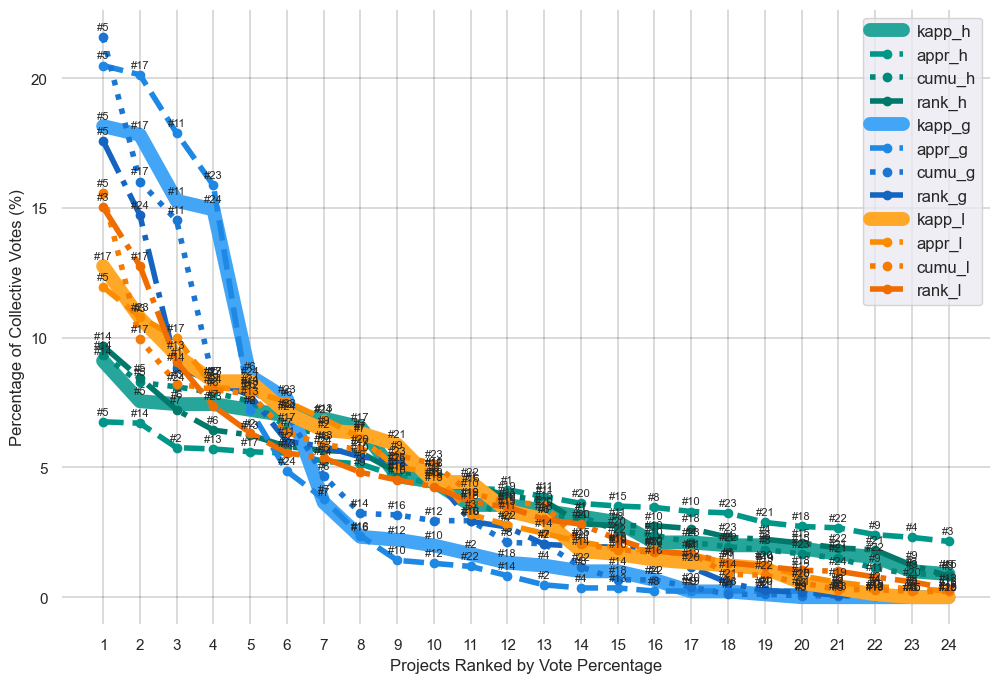

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from itertools import cycle

def visualize_vote_percentages_sorted_with_ids(filenames):
    """
    Visualizes the vote percentage of each project for each outcome file, sorted in descending order,
    with annotations for project IDs. Differentiates '1' methods by shades of orange and '2' methods by shades of teal.

    Parameters:
    - filenames: Dictionary with keys as method labels and values as filenames.
    """

    orange_palette = ['#FFA726', '#FB8C00', '#F57C00', '#EF6C00']  
    teal_palette = ['#26A69A', '#009688', '#00897B', '#00796B']    
    blue_palette = ['#42A5F5', '#1E88E5', '#1976D2', '#1565C0']   

    orange_cycle = cycle(orange_palette)
    teal_cycle = cycle(teal_palette)
    blue_cycle = cycle(blue_palette)


    line_styles = ['-', '--', ':', '-.']
    line_weights = ['10', '4', '4', '4']  

    color_map = {}
    for method in filenames:
        if '_l' in method:
            color_map[method] = next(orange_cycle)
        elif '_g' in method:
            color_map[method] = next(blue_cycle)
        else:
            color_map[method] = next(teal_cycle)

    plots = {}
    for method, filename in filenames.items():
        df = pd.read_csv(filename)
        total_votes = df['Votes'].sum()
        df['Vote_Percentage'] = df['Votes'] / total_votes * 100
        sorted_df = df.sort_values('Vote_Percentage', ascending=False)
        plots[method] = {
            'percentages': sorted_df['Vote_Percentage'].reset_index(drop=True),
            'ids': sorted_df['Id']
        }
        
    plt.figure(figsize=(12, 8))
    for i, (method, data) in enumerate(plots.items()):
        color = color_map[method]
        line_style = line_styles[i % len(line_styles)]
        line_weight = int(line_weights[i % len(line_weights)])

        plt.plot(data['percentages'], marker='o', label=method, color=color, linewidth=line_weight, linestyle=line_style)
        for i, txt in enumerate(data['ids']):
            plt.annotate(txt, (i, data['percentages'][i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

    plt.xlabel('Projects Ranked by Vote Percentage')
    plt.ylabel('Percentage of Collective Votes (%)')
    plt.legend(fontsize=12)
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='black')
    plt.minorticks_on()
    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_facecolor('white')
    plt.xticks(range(len(plots[next(iter(plots))]['percentages'])), range(1, len(plots[next(iter(plots))]['percentages']) + 1))
    plt.show()

filenames = {
    'kapp_h': 'lab_vote/outcome_lab_kapp.csv',
    'appr_h': 'lab_vote/outcome_lab_appr.csv',
    'cumu_h': 'lab_vote/outcome_lab_cumu.csv',
    'rank_h': 'lab_vote/outcome_lab_rank.csv',
    'kapp_g': 'gpt4t_vote/outcome_gpt4t_kapp_1.csv',
    'appr_g': 'gpt4t_vote/outcome_gpt4t_appr_1.csv',
    'cumu_g': 'gpt4t_vote/outcome_gpt4t_cumu_1_corrected.csv',
    'rank_g': 'gpt4t_vote/outcome_gpt4t_rank_1.csv',
    'kapp_l': 'llama_vote/outcome_llama70bq8_kapp_1.csv',
    'appr_l': 'llama_vote/outcome_llama70bq8_appr_1.csv',
    'cumu_l': 'llama_vote/outcome_llama70bq8_cumu_1.csv',
    'rank_l': 'llama_vote/outcome_llama70bq8_rank_1.csv',
}
visualize_vote_percentages_sorted_with_ids(filenames)


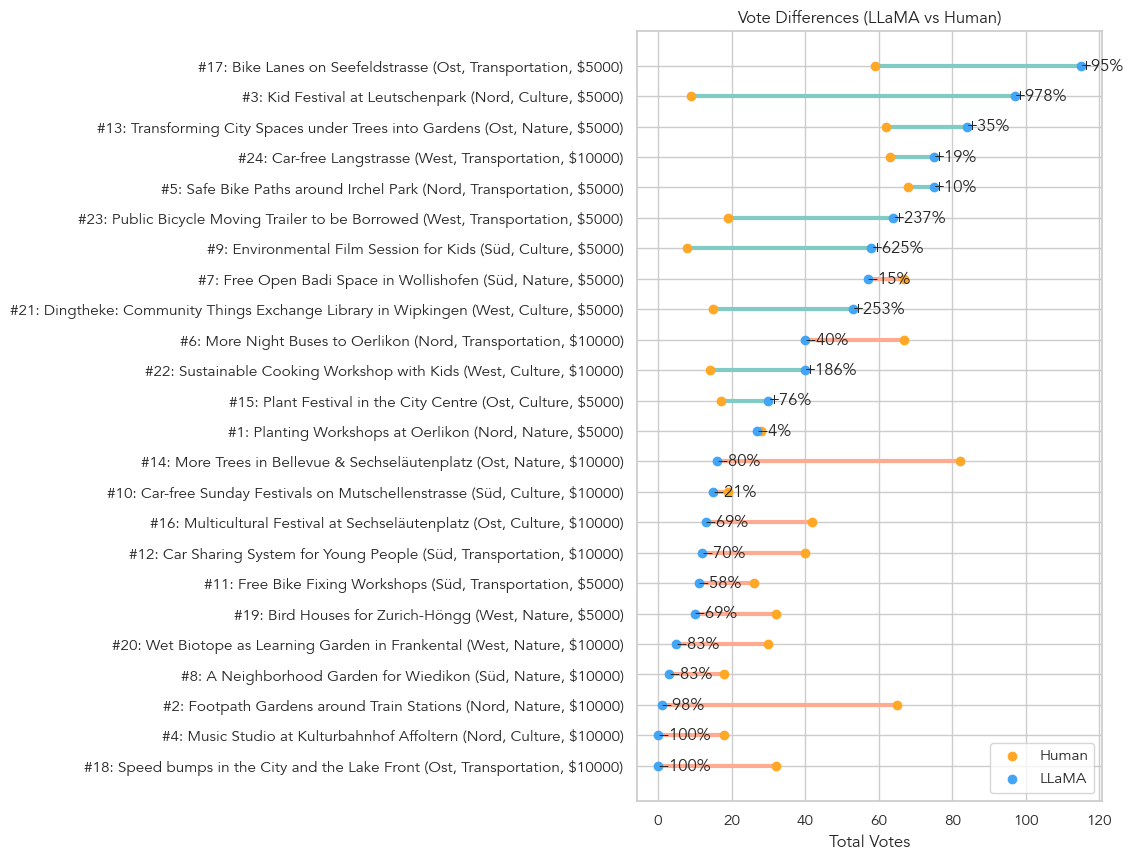

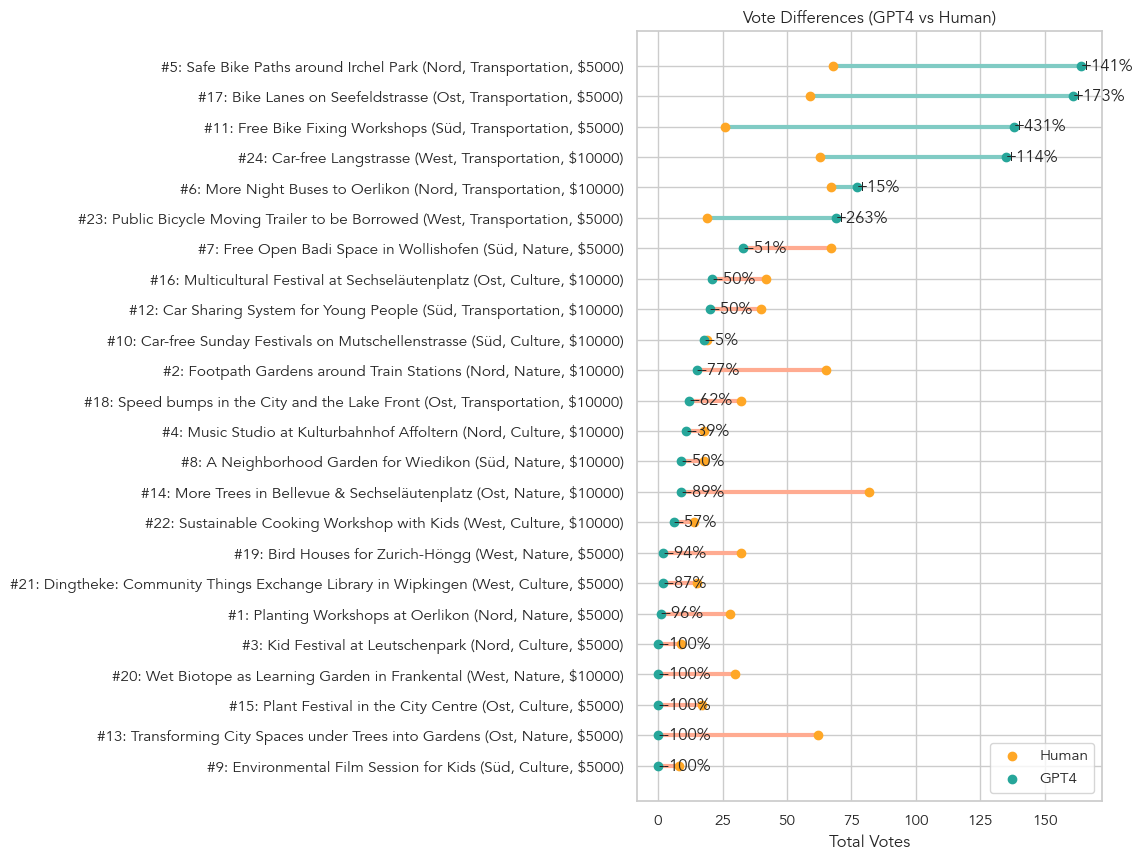

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Avenir'

def parse_project_info(project_info):
    parsed_info = {}
    for key, info in project_info.items():
        parts = info.split(', ')
        name = parts[0]
        details = ', '.join(parts[1:])  
        parsed_info[key] = {'name': name, 'details': details}
    return parsed_info

def visualize_vote_differences(filenames, project_info):
    parsed_info = parse_project_info(project_info)

    kapp_h_df = pd.read_csv(filenames['kapp_h'])
    kapp_llama_df = pd.read_csv(filenames['kapp_l'])
    kapp_g_df = pd.read_csv(filenames['kapp_g'])

    def process_df(df1, df2, suffix_h, suffix_other):
        merged_df = df1[['Id', 'Votes']].merge(df2[['Id', 'Votes']], on='Id', suffixes=(suffix_h, suffix_other))
        merged_df['Diff_Percentage'] = (merged_df['Votes' + suffix_other] - merged_df['Votes' + suffix_h]) / merged_df['Votes' + suffix_h] * 100
        # merged_df.sort_values('Votes' + suffix_other, ascending=False, inplace=True)
        return merged_df

    merged_llama = process_df(kapp_h_df, kapp_llama_df, '_h', '_l')
    merged_gpt = process_df(kapp_h_df, kapp_g_df, '_h', '_g')

    positive_color = '#80CBC4'  
    negative_color = '#FFAB91'
    human_color = '#FFA726'
    llama_color = '#42A5F5'
    gpt_color = '#26A69A'
    line_width = 3
    diff_font_size = 12

    def plot_comparison(merged_df, title, label_h, label_other, other_color, other_label):
        fig, ax = plt.subplots(figsize=(6, 10))
        human_scatter = None
        other_scatter = None
        merged_df.sort_values('Votes' + label_other[-2:], ascending=False, inplace=True)

        y_ticks = range(len(merged_df))
        ax.set_yticks(y_ticks)

        for i, (_, row) in enumerate(merged_df.iterrows()):
            line_color = positive_color if row['Diff_Percentage'] > 0 else negative_color
            diff_sign = '+' if row['Diff_Percentage'] > 0 else '-'
            line = ax.plot([row[label_h], row[label_other]], [i, i], color=line_color, linewidth=line_width, zorder=1)
            human_scatter = ax.scatter([row[label_h]], [i], color=human_color, zorder=2)
            other_scatter = ax.scatter([row[label_other]], [i], color=other_color, zorder=2)
            ax.text(row[label_other], i, f"{diff_sign}{row['Diff_Percentage']:.0f}%", verticalalignment='center', fontsize=diff_font_size)

        ax.set_yticklabels([f"{row['Id']}: {parsed_info[row['Id']]['name'][:60]} ({parsed_info[row['Id']]['details']})" for _, row in merged_df.iterrows()], ha='right')

        ax.invert_yaxis()
        ax.set_xlabel('Total Votes')
        ax.set_title(title)
        ax.set_facecolor('white')
        ax.grid(True)

        ax.legend([human_scatter, other_scatter], ['Human', other_label], loc='lower right')

        plt.show()

    plot_comparison(merged_llama, 'Vote Differences (LLaMA vs Human)', 'Votes_h', 'Votes_l', llama_color, 'LLaMA')
    plot_comparison(merged_gpt, 'Vote Differences (GPT4 vs Human)', 'Votes_h', 'Votes_g', gpt_color, 'GPT4')    

filenames = {
    'kapp_l': 'llama_vote/outcome_llama70bq8_kapp_1.csv',
    'kapp_h': 'lab_vote/outcome_lab_kapp.csv',
    'kapp_g': 'gpt_vote/outcome_kapp.csv',
}

project_info = {
    '#1': 'Planting Workshops at Oerlikon, Nord, Nature, $5000',
    '#2': 'Footpath Gardens around Train Stations, Nord, Nature, $10000',
    '#3': 'Kid Festival at Leutschenpark, Nord, Culture, $5000',
    '#4': 'Music Studio at Kulturbahnhof Affoltern, Nord, Culture, $10000',
    '#5': 'Safe Bike Paths around Irchel Park, Nord, Transportation, $5000',
    '#6': 'More Night Buses to Oerlikon, Nord, Transportation, $10000',
    '#7': 'Free Open Badi Space in Wollishofen, Süd, Nature, $5000',
    '#8': 'A Neighborhood Garden for Wiedikon, Süd, Nature, $10000',
    '#9': 'Environmental Film Session for Kids, Süd, Culture, $5000',
    '#10': 'Car-free Sunday Festivals on Mutschellenstrasse, Süd, Culture, $10000',
    '#11': 'Free Bike Fixing Workshops, Süd, Transportation, $5000',
    '#12': 'Car Sharing System for Young People, Süd, Transportation, $10000',
    '#13': 'Transforming City Spaces under Trees into Gardens, Ost, Nature, $5000',
    '#14': 'More Trees in Bellevue & Sechseläutenplatz, Ost, Nature, $10000',
    '#15': 'Plant Festival in the City Centre, Ost, Culture, $5000',
    '#16': 'Multicultural Festival at Sechseläutenplatz, Ost, Culture, $10000',
    '#17': 'Bike Lanes on Seefeldstrasse, Ost, Transportation, $5000',
    '#18': 'Speed bumps in the City and the Lake Front, Ost, Transportation, $10000',
    '#19': 'Bird Houses for Zurich-Höngg, West, Nature, $5000',
    '#20': 'Wet Biotope as Learning Garden in Frankental, West, Nature, $10000',
    '#21': 'Dingtheke: Community Things Exchange Library in Wipkingen, West, Culture, $5000',
    '#22': 'Sustainable Cooking Workshop with Kids, West, Culture, $10000',
    '#23': 'Public Bicycle Moving Trailer to be Borrowed, West, Transportation, $5000',
    '#24': 'Car-free Langstrasse, West, Transportation, $10000'
}

visualize_vote_differences(filenames, project_info)


In [120]:
def format_latex_with_color(value):
    return f"\\ApplyGradient{{{value:.1f}}}"

def parse_project_info(project_info):
    parsed_info = {}
    for key, info in project_info.items():
        parts = info.split(', ')
        name = parts[0] 
        details = ', '.join(parts[1:])  
        parsed_info[key] = {'name': name, 'details': details}
    return parsed_info

def process_df(df1, df2, suffix_h, suffix_other):
    merged_df = df1[['Id', 'Votes']].merge(df2[['Id', 'Votes']], on='Id', suffixes=(suffix_h, suffix_other))
    merged_df['Diff_Percentage'] = (merged_df['Votes' + suffix_other] - merged_df['Votes' + suffix_h]) / merged_df['Votes' + suffix_h] * 100
    return merged_df

def generate_comparison_table(filenames, project_info):
    parsed_info = parse_project_info(project_info)

    kapp_h_df = pd.read_csv(filenames['kapp_h'])
    kapp_llama_df = pd.read_csv(filenames['kapp_l'])
    kapp_g_df = pd.read_csv(filenames['kapp_g'])

    merged_llama = process_df(kapp_h_df, kapp_llama_df, '_h', '_l')
    merged_gpt = process_df(kapp_h_df, kapp_g_df, '_h', '_g')

    table_df = pd.DataFrame(columns=['Id', 'Name', 'Info', 'LLaMA2 Diff (%)', 'GPT4 Diff (%)'])

    for id, info in parsed_info.items():
        name_detail = f"{id}: {info['name'][:20]} ({info['details']})"
        
        llama_diff_row = merged_llama[merged_llama['Id'] == id]
        gpt_diff_row = merged_gpt[merged_gpt['Id'] == id]

        llama_diff = llama_diff_row['Diff_Percentage'].values[0] if not llama_diff_row.empty else None
        gpt_diff = gpt_diff_row['Diff_Percentage'].values[0] if not gpt_diff_row.empty else None
        
        row = {
            'Id': id,
            'Name': name_detail,
            'Human': 0,
            'LLaMA2 Diff (%)': llama_diff,
            'GPT4 Diff (%)': gpt_diff
        }

        table_df = table_df.append(row, ignore_index=True)
        table_df = table_df.append(row, ignore_index=True)

    # Calculate the average differences
    avg_llama_diff = table_df['LLaMA2 Diff (%)'].abs().mean()
    avg_gpt_diff = table_df['GPT4 Diff (%)'].abs().mean()
    
    # Append the average row
    avg_row = {
        'Name': 'Average',
        'Human': 0,
        'LLaMA2 Diff (%)': avg_llama_diff,
        'GPT4 Diff (%)': avg_gpt_diff
    }
    table_df = table_df.append(avg_row, ignore_index=True)

    # Reorder columns
    table_df = table_df[['Name', 'Human', 'LLaMA2 Diff (%)', 'GPT4 Diff (%)']]
    
    # Convert to CSV format and print
    # csv_format = table_df.to_csv(index=False)
    print(csv_format)

    return table_df

        # Add columns for District, Topic, and Cost
    # table_df['District'] = table_df['Info'].apply(lambda x: x.split(',')[1].strip() if len(x.split(',')) > 1 else None)
    # table_df['Topic'] = table_df['Info'].apply(lambda x: x.split(',')[1].strip() if len(x.split(',')) > 1 else None)
    # table_df['Cost'] = table_df['Info'].apply(lambda x: x.split(',')[2].strip() if len(x.split(',')) > 2 else None)
    # table_df['LLaMA2 Diff (%)'] = table_df['LLaMA2 Diff (%)'].apply(format_latex_with_color)
    # table_df['GPT4 Diff (%)'] = table_df['GPT4 Diff (%)'].apply(format_latex_with_color)
    # Reorder columns
    
    # print(table_df.to_latex(index=False, float_format="%.1f"))


comparison_table = generate_comparison_table(filenames, project_info)
csv_format = comparison_table.to_csv(index=False)
print(csv_format)


Name,Human,LLaMA2 Diff (%),GPT4 Diff (%)
"#1: Planting Workshops a (Nord, Nature, $5000)",0.0,-3.571428571428571,-96.42857142857143
"#1: Planting Workshops a (Nord, Nature, $5000)",0.0,-3.571428571428571,-96.42857142857143
"#2: Footpath Gardens aro (Nord, Nature, $10000)",0.0,-98.46153846153847,-76.92307692307693
"#2: Footpath Gardens aro (Nord, Nature, $10000)",0.0,-98.46153846153847,-76.92307692307693
"#3: Kid Festival at Leut (Nord, Culture, $5000)",0.0,977.7777777777778,-100.0
"#3: Kid Festival at Leut (Nord, Culture, $5000)",0.0,977.7777777777778,-100.0
"#4: Music Studio at Kult (Nord, Culture, $10000)",0.0,-100.0,-38.88888888888889
"#4: Music Studio at Kult (Nord, Culture, $10000)",0.0,-100.0,-38.88888888888889
"#5: Safe Bike Paths arou (Nord, Transportation, $5000)",0.0,10.294117647058822,141.1764705882353
"#5: Safe Bike Paths arou (Nord, Transportation, $5000)",0.0,10.294117647058822,141.1764705882353
"#6: More Night Buses to  (Nord, Transportation, $10000)",0.0,-40.29850746268

/var/folders/b5/wqbw_0tx7wv2s6m_tw4pfw7h0000gq/T/ipykernel_4873/2084371519.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row, ignore_index=True)
/var/folders/b5/wqbw_0tx7wv2s6m_tw4pfw7h0000gq/T/ipykernel_4873/2084371519.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row, ignore_index=True)
/var/folders/b5/wqbw_0tx7wv2s6m_tw4pfw7h0000gq/T/ipykernel_4873/2084371519.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_df = table_df.append(row, ignore_index=True)
/var/folders/b5/wqbw_0tx7wv2s6m_tw4pfw7h0000gq/T/ipykernel_4873/2084371519.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

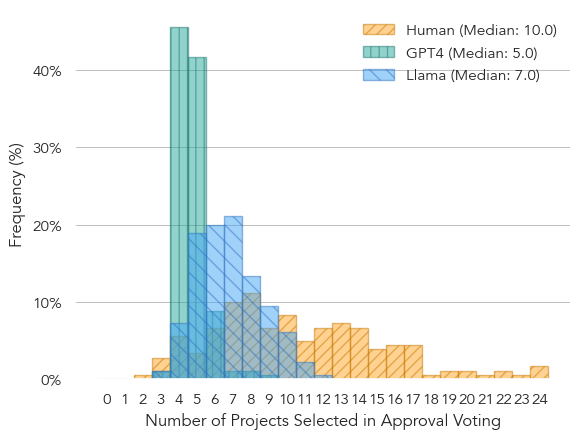

In [88]:
import json
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Avenir'

def load_data(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    if 'Inputs' in data[0]:
        vote_counts = [sum(1 for vote in item['Inputs']['voteA'] if vote != 0) for item in data]
    else:
        vote_counts = [len(item['votes']) for item in data]
    return vote_counts

vote_counts_h = load_data('lab_vote/responses.json')
vote_counts_g = load_data('gpt4t_vote/votes_gpt4t_appr_1.json')
vote_counts_l = load_data('llama_vote/votes_llama70bq8_appr_1.json')

median_h = np.median(vote_counts_h)
median_g = np.median(vote_counts_g)
median_l = np.median(vote_counts_l)

human_color = '#FFA726'
llama_color = '#42A5F5'
gpt_color = '#26A69A'

human_hatch_color = '#C77800' 
llama_hatch_color = '#3173C4' 
gpt_hatch_color = '#1B786D'   

human_hatch = '///'
llama_hatch = '\\\\'
gpt_hatch = '||'


bins = np.arange(26) - 0.5 
plt.hist(vote_counts_h, bins=bins, alpha=0.5, label=f'Human (Median: {median_h})', density=True, color=human_color, hatch=human_hatch, edgecolor=human_hatch_color)
plt.hist(vote_counts_g, bins=bins, alpha=0.5, label=f'GPT4 (Median: {median_g})', density=True, color=gpt_color, hatch=gpt_hatch, edgecolor=gpt_hatch_color)
plt.hist(vote_counts_l, bins=bins, alpha=0.5, label=f'Llama (Median: {median_l})', density=True, color=llama_color, hatch=llama_hatch, edgecolor=llama_hatch_color)
plt.gcf().set_facecolor('white')  
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))

plt.xlabel('Number of Projects Selected in Approval Voting')
plt.ylabel('Frequency (%)')
plt.legend(frameon=False)
plt.xticks(range(25))
plt.grid(axis='y', alpha=0.5)
plt.grid(axis='y', which='major', linestyle='-', linewidth=0.5, alpha=0.7, color='grey')
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.show()


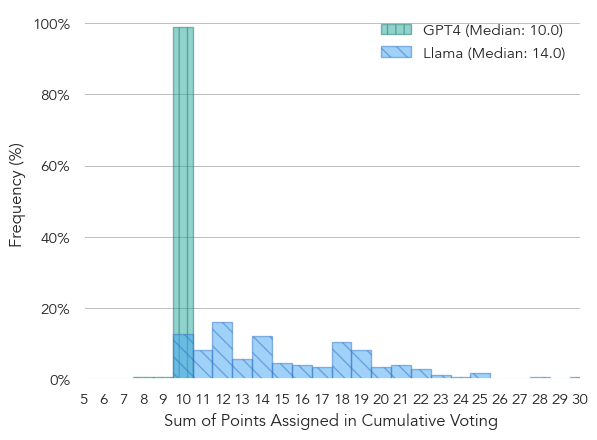

In [89]:
import json
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Avenir'

def load_data_and_sum_points(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    sum_of_points = [sum(votes.values()) for votes in (item['votes'] for item in data)]
    return sum_of_points

sum_of_points_gpt4t = load_data_and_sum_points('gpt4t_vote/votes_gpt4t_cumu_1_corrected.json')
sum_of_points_llama = load_data_and_sum_points('llama_vote/votes_llama70bq8_cumu_1.json')

median_gpt4t = np.median(sum_of_points_gpt4t)
median_llama = np.median(sum_of_points_llama)

gpt_color = '#26A69A'
llama_color = '#42A5F5'
gpt_hatch_color = '#1B786D'  
llama_hatch_color = '#3173C4'  
gpt_hatch = '||'
llama_hatch = '\\\\'

bins = np.arange(max(max(sum_of_points_gpt4t), max(sum_of_points_llama)) + 2) - 0.5 
plt.hist(sum_of_points_gpt4t, bins=bins, alpha=0.5, label=f'GPT4 (Median: {median_gpt4t})', density=True, color=gpt_color, hatch=gpt_hatch, edgecolor=gpt_hatch_color)
plt.hist(sum_of_points_llama, bins=bins, alpha=0.5, label=f'Llama (Median: {median_llama})', density=True, color=llama_color, hatch=llama_hatch, edgecolor=llama_hatch_color)

plt.gca().set_facecolor('white')  
plt.gcf().set_facecolor('white')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))

plt.xlabel('Sum of Points Assigned in Cumulative Voting')
plt.ylabel('Frequency (%)')
# plt.title('Frequency of Sum of Points in Cumulative Voting')
plt.legend(frameon=False)
plt.xticks(np.arange(max(max(sum_of_points_gpt4t), max(sum_of_points_llama)) + 1))
plt.xlim(5,30)

plt.grid(axis='y', which='major', linestyle='-', linewidth=0.5, alpha=0.7, color='grey')

plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False)  
plt.gca().spines['bottom'].set_visible(True)  
plt.gca().spines['left'].set_visible(True) 

plt.show()


In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

def load_data_and_get_correlation(filename):
    df = pd.read_csv(filename)
    df['Id'] = df['Id'].str.replace('#', '').astype(int)
    correlation, p_value = stats.pearsonr(df['Id'], df['Rank'])
    return correlation, p_value

correlation_table = {}
filenames = {
    'kapp_h': 'lab_vote/outcome_lab_kapp.csv',
    'kapp_g': 'gpt_vote/outcome_kapp.csv',
    'kapp_g_rev_id': 'gpt_vote/outcome_reversed_id.csv',
    'kapp_g_rev_order': 'gpt_vote/outcome_reversed_order.csv',
    'kapp_l': 'llama_vote/outcome_llama70bq8_kapp_1.csv',
    'kapp_l_rev_id': 'llama_vote/outcome_llama70bq8_reversed_id_1.csv',
    'kapp_l_rev_order': 'llama_vote/outcome_llama70bq8_reversed_order_1.csv',
}


for key, filename in filenames.items():
    correlation, p_value = load_data_and_get_correlation(filename)
    correlation_table[key] = {
        'Correlation': correlation,
        'P-Value': p_value,
        'Significant': p_value < 0.05  
    }

correlation_df = pd.DataFrame.from_dict(correlation_table, orient='index')
latex_table = correlation_df.style.format({
    'Correlation': "{:.3f}",
    'P-Value': "{:.3f}"
}).to_latex()

print(latex_table)



\begin{tabular}{lrrr}
 & Correlation & P-Value & Significant \\
kapp_h & 0.100 & 0.642 & False \\
kapp_g & 0.013 & 0.952 & False \\
kapp_g_rev_id & -0.089 & 0.680 & False \\
kapp_g_rev_order & -0.020 & 0.926 & False \\
kapp_l & -0.092 & 0.668 & False \\
kapp_l_rev_id & 0.189 & 0.377 & False \\
kapp_l_rev_order & 0.331 & 0.114 & False \\
\end{tabular}



# Trash

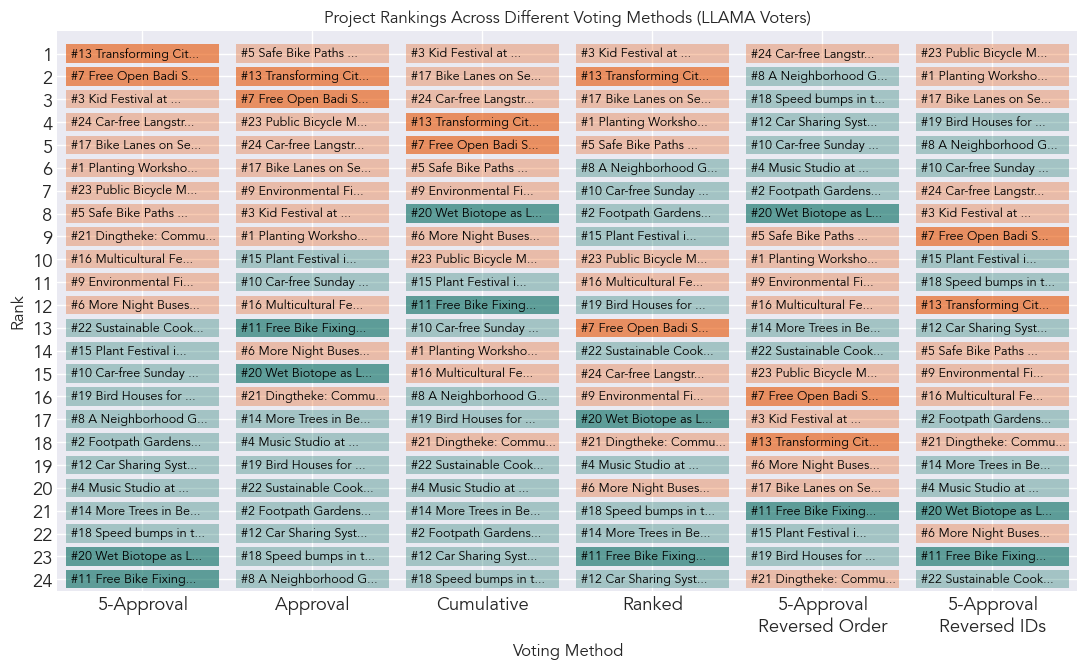

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

filenames = {
    'appr': 'outcome_llama70bq8_appr_2.csv',
    'cumu': 'outcome_llama70bq8_cumu_2.csv',
    'kapp': 'outcome_llama70bq8_kapp_2.csv',
    'rank': 'outcome_llama70bq8_rank_2.csv',
    'reversed_id': 'outcome_llama70bq8_reversed_id_2.csv',
    'reversed_order': 'outcome_llama70bq8_reversed_order_2.csv'
}

instruction_labels = {
    'appr': "Approval",
    'kapp': "5-Approval",
    'cumu': "Cumulative",
    'rank': "Ranked",
    'reversed_order': "5-Approval\nReversed Order",
    'reversed_id': "5-Approval\nReversed IDs"
}

baseline_df = pd.read_csv(filenames['kapp'])
midpoint = len(baseline_df) // 2
baseline_df['Label'] = ['Top' if i < midpoint else 'Bottom' for i in range(len(baseline_df))]
baseline_df['Alpha'] = 0.3  # Default alpha for all projects
baseline_df.loc[baseline_df['Rank'] == 1, 'Alpha'] = 0.6  
baseline_df.loc[baseline_df['Rank'] == 2, 'Alpha'] = 0.6 
baseline_df.loc[baseline_df['Rank'] == 23, 'Alpha'] = 0.6 
baseline_df.loc[baseline_df['Rank'] == 24, 'Alpha'] = 0.6  

all_dfs = []

for method, filename in filenames.items():
    df = pd.read_csv(filename)
    df = df.merge(baseline_df[['Id', 'Label']], on='Id', how='left')
    df['Method'] = method
    df['Color'] = df['Id'].map(baseline_df.set_index('Id')['Rank'].apply(lambda x: plt.cm.viridis((x-1)/(len(baseline_df)-1))))
    all_dfs.append(df)

combined_df = pd.concat(all_dfs)
combined_df = combined_df.merge(baseline_df[['Id', 'Alpha']], on='Id', how='left')
combined_df['Alpha'] = combined_df['Alpha'].astype(float)

top_color = '#E65100'
bottom_color = '#00695C'

plt.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.weight'] = 'bold'

fig, ax = plt.subplots(figsize=(12, 7))

methods_order = ['kapp', 'appr', 'cumu', 'rank', 'reversed_order', 'reversed_id']
combined_df['Method'] = pd.Categorical(combined_df['Method'], categories=methods_order, ordered=True)

combined_df['Color'] = combined_df['Label'].map({'Top': top_color, 'Bottom': bottom_color})

bar_width = 0.9
bar_height = 0.8

for method_pos, method in enumerate(methods_order):
    method_df = combined_df[combined_df['Method'] == method].copy()
    for _, row in method_df.iterrows():
        left_edge = method_pos - bar_width / 2
        ax.barh(y=row['Rank'], width=bar_width, height=bar_height, left=left_edge,
                color=row['Color'], alpha=row['Alpha'], edgecolor='none')
        text_position = left_edge + 0.03
        ax.text(text_position, row['Rank'], f"{row['Id']} {row['Name'][:16]}...",
                ha='left', va='center', fontsize=9, color='black')

ax.set_xticks(range(len(methods_order)))
ax.set_xticklabels([instruction_labels[method] for method in methods_order], fontweight='bold')
ax.set_xlabel('Voting Method', fontsize=12, fontweight='bold')
ax.set_ylabel('Rank', fontsize=12, fontweight='bold')
ax.set_title('Project Rankings Across Different Voting Methods (LLAMA Voters)', fontsize=12, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both', length=0)  

y_ticks = np.arange(1, len(baseline_df) + 1)
ax.set_yticks(y_ticks)
ax.set_yticklabels(map(str, y_ticks))
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(0, 24.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1, right=0.9, left=0.05)
plt.show()

In [10]:
import pandas as pd
from scipy.stats import kendalltau

kendalls_tau_results = {}

# Calculate Kendall's Tau for each method compared to the baseline 'kapp' method
for method, filepath in filenames.items():
    if method != 'kapp':
        current_df = pd.read_csv(filepath)
        merged_df = baseline_df.merge(current_df, on='Id', suffixes=('_baseline', f'_{method}'))
        tau, p_value = kendalltau(merged_df['Rank_baseline'], merged_df[f'Rank_{method}'])
        kendalls_tau_results[method] = tau

for method, tau in kendalls_tau_results.items():
    print(f"Kendall's Tau for {method} compared to kapp: {tau}")

Kendall's Tau for appr compared to kapp: 0.5507246376811594
Kendall's Tau for cumu compared to kapp: 0.5434782608695652
Kendall's Tau for rank compared to kapp: 0.4565217391304348
Kendall's Tau for reversed_id compared to kapp: 0.3115942028985507
Kendall's Tau for reversed_order compared to kapp: -0.18115942028985507


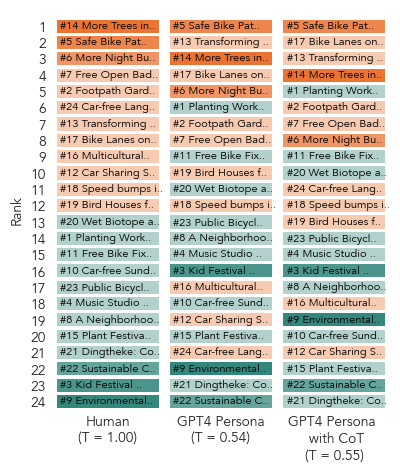

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_kendalls_tau(filenames, baseline_filename):
    baseline_df = pd.read_csv(baseline_filename)
    tau_values = {}
    for method, filename in filenames.items():
        df = pd.read_csv(filename)
        merged_df = baseline_df.merge(df, on='Id', suffixes=('_1', '_2'))
        tau, _ = kendalltau(merged_df['Rank_1'], merged_df['Rank_2'])
        tau_values[method] = tau
    return tau_values

def visualize_project_rankings(filenames, instruction_labels, top_color='#E65100', bottom_color='#00695C'):
    """
    Visualizes project rankings across different voting methods.
    """

    tau_values = calculate_kendalls_tau(filenames, filenames['kapp_h'])
    updated_instruction_labels = {}
    for method, label in instruction_labels.items():
        tau_str = f"\n(T = {tau_values[method]:.2f})" if method in tau_values else ""
        updated_instruction_labels[method] = label + tau_str 

    kapp_h_filename = filenames.get('kapp_h', filenames.get('kapp_h'))
    baseline_df = pd.read_csv(kapp_h_filename)
    midpoint = len(baseline_df) // 2
    baseline_df['Label'] = ['Top' if i < midpoint else 'Bottom' for i in range(len(baseline_df))]
    baseline_df['Alpha'] = 0.3 
    baseline_df.loc[baseline_df['Rank'] == 1, 'Alpha'] = 0.8  
    baseline_df.loc[baseline_df['Rank'] == 2, 'Alpha'] = 0.7 
    baseline_df.loc[baseline_df['Rank'] == 3, 'Alpha'] = 0.6 
    baseline_df.loc[baseline_df['Rank'] == 22, 'Alpha'] = 0.6 
    baseline_df.loc[baseline_df['Rank'] == 23, 'Alpha'] = 0.7 
    baseline_df.loc[baseline_df['Rank'] == 24, 'Alpha'] = 0.8  

    all_dfs = []

    for method, filename in filenames.items():
        df = pd.read_csv(filename)
        df = df.merge(baseline_df[['Id', 'Label']], on='Id', how='left')
        df['Method'] = method
        df['Color'] = df['Id'].map(baseline_df.set_index('Id')['Rank'].apply(lambda x: plt.cm.viridis((x-1)/(len(baseline_df)-1))))
        all_dfs.append(df)

    combined_df = pd.concat(all_dfs)
    combined_df = combined_df.merge(baseline_df[['Id', 'Alpha']], on='Id', how='left')
    combined_df['Alpha'] = combined_df['Alpha'].astype(float)

    plt.rcParams['font.family'] = 'Avenir'

    fig, ax = plt.subplots(figsize=(4, 5), facecolor='white')  
    ax.set_facecolor('white')
    methods_order = list(instruction_labels.keys())
    combined_df['Method'] = pd.Categorical(combined_df['Method'], categories=methods_order, ordered=True)

    combined_df['Color'] = combined_df['Label'].map({'Top': top_color, 'Bottom': bottom_color})

    bar_width = 0.9
    bar_height = 0.8

    for method_pos, method in enumerate(methods_order):
        method_df = combined_df[combined_df['Method'] == method].copy()
        for _, row in method_df.iterrows():
            left_edge = method_pos - bar_width / 2
            ax.barh(y=row['Rank'], width=bar_width, height=bar_height, left=left_edge,
                    color=row['Color'], alpha=row['Alpha'], edgecolor='none')
            text_position = left_edge + 0.03
            ax.text(text_position, row['Rank'], f"{row['Id']} {row['Name'][:13]}..",
                    ha='left', va='center', fontsize=8, color='black')

    ax.set_xticks(range(len(methods_order)))
    ax.set_xticklabels([updated_instruction_labels[method] for method in methods_order], fontsize=10)

    # ax.set_xlabel('Voting Method', fontsize=12, fontweight='bold')
    ax.set_ylabel('Rank', fontsize=10, fontweight='bold')
    # ax.set_title('Project Rankings Across Different Voting Methods (LLAMA Voters)', fontsize=12, fontweight='bold')
    mask = np.triu(np.ones_like(combined_df, dtype=bool))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both', length=0)  

    y_ticks = np.arange(1, len(baseline_df) + 1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(map(str, y_ticks), fontsize=10)
    ax.set_xlim(-0.5, len(methods_order) - 0.5)
    ax.set_ylim(0, max(baseline_df['Rank']) + 0.5)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.1, right=0.9, left=0.05)
    plt.savefig("chain-of-thoughts.pdf", format='pdf')
    plt.show()

filenames = {
    'kapp_h': 'lab_vote/outcome_lab_kapp.csv',
    'persona': 'gpt_persona/temp1/gpt_outcome.csv',
    'persona_cot': 'gpt_cot/gpt_outcome.csv',
}

instruction_labels = {
    'kapp_h': 'Human',
    'persona': 'GPT4 Persona',
    'persona_cot': 'GPT4 Persona \n with CoT',
}

visualize_project_rankings(filenames, instruction_labels)